In [1]:
from model.resnet import *
from model.effnet import *
from model.unet import *
from utils.metrics import *
from utils.losses import *

import os
import pandas as pd
import warnings
import numpy as np
from skimage import io, transform
from rasterio.features import rasterize
from shapely.ops import cascaded_union, unary_union
from shapely.geometry import Polygon
from shapely.errors import ShapelyDeprecationWarning
from torch.utils.data import Dataset
import pickle
import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
from pytorch_metric_learning import losses
import copy

from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import timm
from torch.cuda import amp
from tqdm import tqdm
import torch.optim as optim
from time import time

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore")

c:\Users\Yoga 6 R5\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check file or directory is exist
train_df = pd.read_csv('ForestNetDataset/train_new.csv')
val_df = pd.read_csv('ForestNetDataset/val_new.csv')
test_df = pd.read_csv('ForestNetDataset/test_new.csv')

train_df.head()

,label,merged_label,latitude,longitude,year,example_path
0,Grassland shrubland,Grassland shrubland,-1.720266,115.006996,2016,-1.720266384577504_115.00699582064485
1,Grassland shrubland,Grassland shrubland,-2.709149,113.340780,2016,-2.7091489238834305_113.3407801546713
2,Timber plantation,Plantation,-0.652245,109.920619,2012,-0.6522445100247509_109.9206187702712
3,Oil palm plantation,Plantation,-1.347868,110.527867,2014,-1.3478682873694396_110.52786683455288
4,Grassland shrubland,Grassland shrubland,-2.885256,111.584100,2016,-2.8852555512190485_111.5840999668356


In [4]:
from torch.utils.data import Dataset
import torch
import numpy as np
import os
from skimage import io
from rasterio.features import rasterize
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
import pickle


class ForestDataset(Dataset):
    """Forest dataset."""

    def __init__(
        self,
        csv_file_to_df,
        root_dir="ForestNetDataset",
        transform=None,
        types="classifier",
    ):
        self.csv = csv_file_to_df
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_int = {
            "Grassland shrubland": 0,
            "Other": 1,
            "Plantation": 2,
            "Smallholder agriculture": 3,
        }
        self.types = types

    def __len__(self):
        return len(self.csv)

    def poly_from_utm(self, polygon):
        poly_pts = []
        if isinstance(polygon, Polygon):
            for i in np.array(polygon.exterior.coords):
                poly_pts.append(tuple(i))
        elif isinstance(polygon, MultiPolygon):
            for p in polygon.geoms:
                for i in np.array(p.exterior.coords):
                    poly_pts.append(tuple(i))
        else:
            raise ValueError(f"Unsupported geometry type: {type(polygon)}")
        return Polygon(poly_pts)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.csv.iloc[idx, 0]
        merged_label = self.csv.iloc[idx, 1]
        lat = self.csv.iloc[idx, 2]
        long = self.csv.iloc[idx, 3]
        year = self.csv.iloc[idx, 4]
        folder = self.csv.iloc[idx, 5]

        ## Load the image and auxiliary
        image_path = os.path.join(
            self.root_dir, "examples", folder, "images", "visible", "composite.png"
        )
        slope_path = os.path.join(
            self.root_dir, "examples", folder, "auxiliary", "srtm.npy"
        )
        forest_loss_path = os.path.join(
            self.root_dir, "examples", folder, "forest_loss_region.pkl"
        )

        image = io.imread(image_path)
        slope = np.load(slope_path)

        ## Get the segmentation map
        with open(forest_loss_path, "rb") as f:
            data = pickle.load(f)

        nx, ny = 332, 332
        xy_array = np.empty((0, 2))

        if isinstance(data, (Polygon, MultiPolygon)):
            poly_shp = [self.poly_from_utm(data)]
        else:
            poly_shp = [self.poly_from_utm(poly) for poly in data]

        mask = rasterize(shapes=poly_shp, out_shape=(332, 332))
        seg = np.array(mask)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        image = torch.from_numpy(image).type(torch.float)
        image = image.permute(2, 0, 1)
        seg = torch.from_numpy(seg).type(torch.uint8)
        slope = torch.from_numpy(slope).type(torch.float)

        merged_label = self.label_to_int[merged_label]

        image = image[:, 86:246, 86:246]
        seg = seg[86:246, 86:246]
        slope = slope[1]
        slope = slope[86:246, 86:246]
        if self.types == "classifier":
            return image, seg, slope, merged_label
        else:
            return image, seg, merged_label

In [5]:
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Rotate(270),
        A.ElasticTransform(
            p=0.4, alpha=120, sigma=120 * 0.05, alpha_affine=None
        ),
    ]
)

In [6]:
# Initialization several arguments for training
BATCH_SIZE = 16
DEVICE = device = "cuda:0" if torch.cuda.is_available() else "cpu"
LR = 0.001
EPOCH = 20
nbClass = 4

In [7]:
# Load Dataset and Create DataLoader For Classification
train_dataset = ForestDataset( csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset( csv_file_to_df=val_df)
test_dataset = ForestDataset( csv_file_to_df=test_df)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

# Load Dataset and Create DataLoader For Representation Learning
train_dataset_re = ForestDataset( csv_file_to_df=train_df, transform=transform, types="projection")
val_dataset_re = ForestDataset( csv_file_to_df=val_df, types="projection")
test_dataset_re = ForestDataset( csv_file_to_df=test_df, types="projection")
trainloader_re = torch.utils.data.DataLoader(train_dataset_re, batch_size=BATCH_SIZE,shuffle=True)
valloader_re = torch.utils.data.DataLoader(val_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
testloader_re = torch.utils.data.DataLoader(test_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
dataloaders_re = {'train': trainloader_re, 'val':valloader_re}

In [8]:
dataiter = iter(trainloader)
images, seg, slope, labels = dataiter.__next__()

print('images shape on PyTroch : ', images.size())
print('seg shape on PyTroch : ', seg.size())
# print('slope shape on PyTroch : ', slope.size())
print('labels shape on PyTroch : ', labels.size())

images shape on PyTroch :  torch.Size([16, 3, 160, 160])
seg shape on PyTroch :  torch.Size([16, 160, 160])
labels shape on PyTroch :  torch.Size([16])


In [9]:
sample = next(iter(trainloader_re))[1]
print(sample.shape)

sample_target = next(iter(valloader_re))[1]
print(sample_target.shape)

torch.Size([16, 160, 160])
torch.Size([16, 160, 160])


In [11]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

In [12]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import importlib
import model.TransResNet # Import your module first

# Force reload the module
importlib.reload(model.TransResNet)

# Now you can import from the reloaded module
from model.TransResNet import create_TransResNet
import numpy as np
from tqdm import tqdm

# Create the model
model = create_TransResNet(img_dim=160, in_channels=3, out_channels=1, num_classes=4)
model = model.to(DEVICE)

# Define loss functions
segmentation_criterion = nn.BCEWithLogitsLoss()
classification_criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)


def train_model(model, dataloaders, criteria, optimizer, num_epochs=25):
    segmentation_criterion, classification_criterion = criteria
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, segs, slopes, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(DEVICE)
                segs = segs.to(DEVICE).unsqueeze(1)  # Add channel dimension
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    seg_outputs, class_outputs = model(inputs)

                    # Check sizes
                    if seg_outputs.shape != segs.shape:
                        raise ValueError(
                            f"Segmentation output shape {seg_outputs.shape} does not match target shape {segs.shape}"
                        )

                    seg_loss = segmentation_criterion(seg_outputs, segs.float())
                    class_loss = classification_criterion(class_outputs, labels)
                    loss = seg_loss + class_loss

                    _, preds = torch.max(class_outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Update acc_dict and loss_dict
            acc_dict[phase].append(epoch_acc.item())
            loss_dict[phase].append(epoch_loss)

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    print(f"Best val Acc: {best_acc:4f}")

    model.load_state_dict(best_model_wts)
    return model


# Train the model
model = train_model(
    model,
    dataloaders,
    (segmentation_criterion, classification_criterion),
    optimizer,
    num_epochs=EPOCH,
)

# Save the model
torch.save(model.state_dict(), "Trained_Models/TransResNet.pth")

Epoch 1/20
----------


100%|██████████| 23/23 [18:25<00:00, 48.08s/it]


train Loss: 13.8143 Acc: 0.3011


100%|██████████| 8/8 [01:54<00:00, 14.35s/it]


val Loss: 67.0390 Acc: 0.3967

Epoch 2/20
----------


100%|██████████| 23/23 [12:27<00:00, 32.49s/it]


train Loss: 2.7425 Acc: 0.3398


100%|██████████| 8/8 [01:10<00:00,  8.87s/it]


val Loss: 1.7801 Acc: 0.3719

Epoch 3/20
----------


100%|██████████| 23/23 [12:19<00:00, 32.15s/it]


train Loss: 1.7226 Acc: 0.3702


100%|██████████| 8/8 [01:28<00:00, 11.00s/it]


val Loss: 1.7187 Acc: 0.3802

Epoch 4/20
----------


100%|██████████| 23/23 [11:57<00:00, 31.20s/it]


train Loss: 1.7283 Acc: 0.3591


100%|██████████| 8/8 [01:09<00:00,  8.66s/it]


val Loss: 1.7020 Acc: 0.3719

Epoch 5/20
----------


100%|██████████| 23/23 [11:46<00:00, 30.73s/it]


train Loss: 1.7287 Acc: 0.3591


100%|██████████| 8/8 [01:09<00:00,  8.70s/it]


val Loss: 1.7257 Acc: 0.3719

Epoch 6/20
----------


100%|██████████| 23/23 [11:54<00:00, 31.07s/it]


train Loss: 1.7261 Acc: 0.3591


100%|██████████| 8/8 [01:09<00:00,  8.63s/it]


val Loss: 1.7129 Acc: 0.3719

Epoch 7/20
----------


100%|██████████| 23/23 [11:47<00:00, 30.77s/it]


train Loss: 1.7039 Acc: 0.3591


100%|██████████| 8/8 [01:08<00:00,  8.54s/it]


val Loss: 1.6893 Acc: 0.3719

Epoch 8/20
----------


100%|██████████| 23/23 [11:43<00:00, 30.60s/it]


train Loss: 1.6955 Acc: 0.3591


100%|██████████| 8/8 [01:08<00:00,  8.57s/it]


val Loss: 1.6711 Acc: 0.3719

Epoch 9/20
----------


100%|██████████| 23/23 [11:43<00:00, 30.60s/it]


train Loss: 1.6930 Acc: 0.3591


100%|██████████| 8/8 [01:10<00:00,  8.77s/it]


val Loss: 1.6644 Acc: 0.3719

Epoch 10/20
----------


100%|██████████| 23/23 [11:47<00:00, 30.75s/it]


train Loss: 1.6821 Acc: 0.3591


100%|██████████| 8/8 [01:08<00:00,  8.55s/it]


val Loss: 1.6549 Acc: 0.3719

Epoch 11/20
----------


100%|██████████| 23/23 [11:39<00:00, 30.43s/it]


train Loss: 1.7213 Acc: 0.3591


100%|██████████| 8/8 [01:09<00:00,  8.68s/it]


val Loss: 1.6743 Acc: 0.3719

Epoch 12/20
----------


100%|██████████| 23/23 [11:53<00:00, 31.03s/it]


train Loss: 1.6795 Acc: 0.3591


100%|██████████| 8/8 [01:08<00:00,  8.61s/it]


val Loss: 1.6523 Acc: 0.3719

Epoch 13/20
----------


100%|██████████| 23/23 [12:00<00:00, 31.33s/it]


train Loss: 1.6838 Acc: 0.3591


100%|██████████| 8/8 [01:11<00:00,  8.91s/it]


val Loss: 1.6376 Acc: 0.3719

Epoch 14/20
----------


100%|██████████| 23/23 [11:54<00:00, 31.05s/it]


train Loss: 1.6617 Acc: 0.3591


100%|██████████| 8/8 [01:09<00:00,  8.66s/it]


val Loss: 1.6315 Acc: 0.3719

Epoch 15/20
----------


100%|██████████| 23/23 [11:38<00:00, 30.35s/it]


train Loss: 1.6536 Acc: 0.3591


100%|██████████| 8/8 [01:08<00:00,  8.52s/it]


val Loss: 1.6231 Acc: 0.3719

Epoch 16/20
----------


100%|██████████| 23/23 [11:40<00:00, 30.44s/it]


train Loss: 1.6443 Acc: 0.3591


100%|██████████| 8/8 [01:07<00:00,  8.48s/it]


val Loss: 1.6177 Acc: 0.3719

Epoch 17/20
----------


100%|██████████| 23/23 [11:29<00:00, 30.00s/it]


train Loss: 1.6439 Acc: 0.3591


100%|██████████| 8/8 [01:07<00:00,  8.41s/it]


val Loss: 1.6529 Acc: 0.3719

Epoch 18/20
----------


100%|██████████| 23/23 [11:27<00:00, 29.89s/it]


train Loss: 1.6626 Acc: 0.3591


100%|██████████| 8/8 [01:08<00:00,  8.60s/it]


val Loss: 1.6100 Acc: 0.3719

Epoch 19/20
----------


100%|██████████| 23/23 [11:29<00:00, 29.96s/it]


train Loss: 1.6317 Acc: 0.3812


100%|██████████| 8/8 [01:07<00:00,  8.39s/it]


val Loss: 1.6072 Acc: 0.4050

Epoch 20/20
----------


100%|██████████| 23/23 [11:28<00:00, 29.92s/it]


train Loss: 1.6315 Acc: 0.3950


100%|██████████| 8/8 [01:07<00:00,  8.44s/it]


val Loss: 1.6010 Acc: 0.4050

Best val Acc: 0.404959


In [22]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from model.TransUnet import create_transunet
# import numpy as np
# from tqdm import tqdm
# from torch.cuda.amp import GradScaler, autocast
# from torch.utils.data import DataLoader
# from torch.optim.lr_scheduler import CosineAnnealingLR

# # Constants
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# BATCH_SIZE = 16
# LR = 0.001
# EPOCH = 20
# ACCUMULATION_STEPS = 4  # Adjust based on your memory constraints
# NUM_WORKERS = 4  # Adjust based on your CPU cores

# # Create the model
# model = create_transunet(img_dim=160, in_channels=3, out_channels=1, num_classes=4)
# model = model.to(DEVICE)

# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs!")
#     model = nn.DataParallel(model)

# # Define loss functions
# segmentation_criterion = nn.BCEWithLogitsLoss()
# classification_criterion = nn.CrossEntropyLoss()

# # Define optimizer and scheduler
# optimizer = optim.Adam(model.parameters(), lr=LR)
# scheduler = CosineAnnealingLR(optimizer, T_max=EPOCH)

# # Create DataLoaders with optimized settings
# # ... (previous imports)
# import traceback

# # ... (previous code)

# # Modify these lines in your code
# NUM_WORKERS = 0  # Set to 0 to disable multiprocessing
# train_loader = DataLoader(
#     train_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=NUM_WORKERS,
#     pin_memory=True,
# )
# val_loader = DataLoader(
#     val_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=NUM_WORKERS,
#     pin_memory=True,
# )
# dataloaders = {"train": train_loader, "val": val_loader}


# def train_model(model, dataloaders, criteria, optimizer, scheduler, num_epochs=25):
#     scaler = GradScaler()
#     segmentation_criterion, classification_criterion = criteria
#     best_model_wts = model.state_dict()
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print(f"Epoch {epoch+1}/{num_epochs}")
#         print("-" * 10)

#         for phase in ["train", "val"]:
#             if phase == "train":
#                 model.train()
#             else:
#                 model.eval()

#             running_loss = 0.0
#             running_corrects = 0

#             try:
#                 for i, (inputs, segs, slopes, labels) in enumerate(
#                     tqdm(dataloaders[phase])
#                 ):
#                     inputs = inputs.to(DEVICE)
#                     segs = segs.to(DEVICE).unsqueeze(1)
#                     labels = labels.to(DEVICE)

#                     # Mixed precision training
#                     with autocast():
#                         seg_outputs, class_outputs = model(inputs)
#                         seg_loss = segmentation_criterion(seg_outputs, segs.float())
#                         class_loss = classification_criterion(class_outputs, labels)
#                         loss = seg_loss + class_loss

#                     # Gradient accumulation
#                     loss = loss / ACCUMULATION_STEPS

#                     if phase == "train":
#                         scaler.scale(loss).backward()

#                         if (i + 1) % ACCUMULATION_STEPS == 0:
#                             scaler.step(optimizer)
#                             scaler.update()
#                             optimizer.zero_grad()

#                     running_loss += loss.item() * ACCUMULATION_STEPS * inputs.size(0)
#                     _, preds = torch.max(class_outputs, 1)
#                     running_corrects += torch.sum(preds == labels.data)

#             except Exception as e:
#                 print(f"Error occurred during {phase} phase:")
#                 print(traceback.format_exc())
#                 raise e

#             if phase == "train":
#                 scheduler.step()

#             epoch_loss = running_loss / len(dataloaders[phase].dataset)
#             epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

#             print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

#             # Update acc_dict and loss_dict
#             acc_dict[phase].append(epoch_acc.item())
#             loss_dict[phase].append(epoch_loss)

#             if phase == "val" and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = model.state_dict()

#         print()

#     print(f"Best val Acc: {best_acc:4f}")

#     model.load_state_dict(best_model_wts)
#     return model


# # Train the model
# model = train_model(
#     model,
#     dataloaders,
#     (segmentation_criterion, classification_criterion),
#     optimizer,
#     scheduler,
#     num_epochs=EPOCH,
# )

# # Save the model
# torch.save(model.state_dict(), "transunet_model.pth")

Epoch 1/20
----------


 22%|██▏       | 5/23 [03:54<13:54, 46.36s/it]

: 

Test Accuracy: 0.4631


<Figure size 2200x800 with 0 Axes>

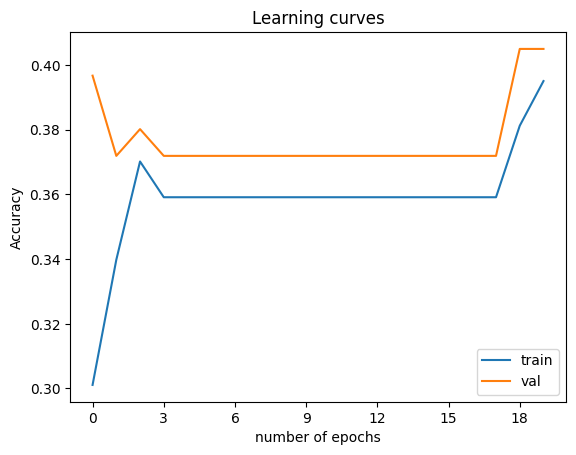

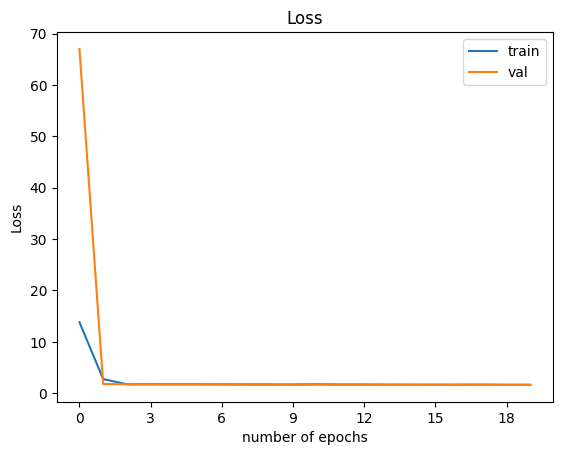

In [14]:
# Test the model
model.eval()
test_corrects = 0
test_total = 0

with torch.no_grad():
    for inputs, segs, slopes, labels in testloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        seg_outputs, class_outputs = model(inputs)
        _, preds = torch.max(class_outputs, 1)

        test_corrects += torch.sum(preds == labels.data)
        test_total += labels.size(0)

test_acc = test_corrects.double() / test_total
print(f"Test Accuracy: {test_acc:.4f}")

# Visualize results
show_curves(acc_dict, loss_dict)

## Multimodal SuperCon using Vision Transformer

In [18]:
import torch
import torch.nn as nn
import timm
from torch.optim import lr_scheduler
from collections import defaultdict
from time import time
import importlib
import model.ViTrainer

importlib.reload(model.ViTrainer)
from model.ViTrainer import VisionTransformerMLP, train_vit_scl
import sys

# Assuming you have already defined your device, train_dataset, and dataloaders_re

# Create the VisionTransformerMLP model
vit_model = VisionTransformerMLP(
    model_name="vit_base_patch16_224",
    num_classes=4,
    dropout=0.1,  # Reduced dropout as per the paper's recommendations
    img_size=160,
    dataset_size=len(train_dataset),
)
vit_model = vit_model.to(device)

# Define loss function, optimizer, and scheduler
criterion = SupervisedContrastiveLoss()  # Make sure you have this loss function defined
optimizer = torch.optim.AdamW(
    vit_model.parameters(), lr=0.001, weight_decay=0.01
)  # Changed to AdamW with weight decay
scheduler = lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=20, eta_min=0
)  # Changed to CosineAnnealingLR

# Train the model
trained_vit_model, training_history = train_vit_scl(
    vit_model,
    criterion,
    optimizer,
    scheduler,
    num_epochs=20,
    dataloaders=dataloaders_re,
    device=device,
    patience=5,
    save_path="best_vit_model.pth",
    use_mixup=True,
    mixup_alpha=0.2,
)

# Print training results
print("Training completed.")
print(f"Final training loss: {training_history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {training_history['val_loss'][-1]:.4f}")
print(f"Final training accuracy: {training_history['train_acc'][-1]:.4f}")
print(f"Final validation accuracy: {training_history['val_acc'][-1]:.4f}")

Training...
Epoch 1/20
----------
Train Loss: 2.3288 Acc: 0.1271
Val Loss: 2.2532 Acc: 0.0744
Saved best model to best_vit_model.pth
Epoch 2/20
----------
Train Loss: 2.2917 Acc: 0.1271
Val Loss: 2.2532 Acc: 0.0744
Epoch 3/20
----------
Training complete in 0h 13m 49s
Best Loss: 2.253154984190444


KeyboardInterrupt: 

In [20]:
import torch
import torch.nn as nn
import timm
from torch.optim import lr_scheduler, AdamW
from collections import defaultdict
from time import time
import importlib
import model.ViTrainer

importlib.reload(model.ViTrainer)
from model.ViTrainer import (
    VisionTransformerMLP,
    train_representation,
    train_classifier,
)
import sys

# Assuming you have already defined your device, train_dataset, and dataloaders_re

# Create the VisionTransformerMLP model
vit_model = VisionTransformerMLP(
    model_name="vit_base_patch16_224",
    num_classes=4,
    dropout=0.1,
    img_size=160,
    dataset_size=len(train_dataset),
)
vit_model = vit_model.to(device)

# Stage 1: Representation Learning
print("Stage 1: Representation Learning")
criterion_rep = SupervisedContrastiveLoss()
optimizer_rep = torch.optim.Adam(vit_model.parameters(), lr=0.001, weight_decay=0.01)
# scheduler_rep = lr_scheduler.CosineAnnealingLR(optimizer_rep, T_max=20, eta_min=0)
scheduler_rep = lr_scheduler.StepLR(optimizer_rep, step_size = 7, gamma=0.1)

vit_model, rep_history = train_representation(
    vit_model,
    criterion_rep,
    optimizer_rep,
    scheduler_rep,
    num_epochs=20,
    dataloaders=dataloaders_re,
    device=device,
    patience=5,
)



Stage 1: Representation Learning
Epoch 1/20
----------
Train Loss: 2.3115
Val Loss: 2.2532
Epoch 2/20
----------
Train Loss: 2.3099
Val Loss: 2.2532
Epoch 3/20
----------
Train Loss: 2.2887
Val Loss: 2.2532
Epoch 4/20
----------
Train Loss: 2.3325
Val Loss: 2.2532
Epoch 5/20
----------
Train Loss: 2.3225
Val Loss: 2.2532
Epoch 6/20
----------
Train Loss: 2.2967
Val Loss: 2.2532
Early stopping after 6 epochs
Training complete in 0h 37m 52s
Best Loss: 2.253154515234892


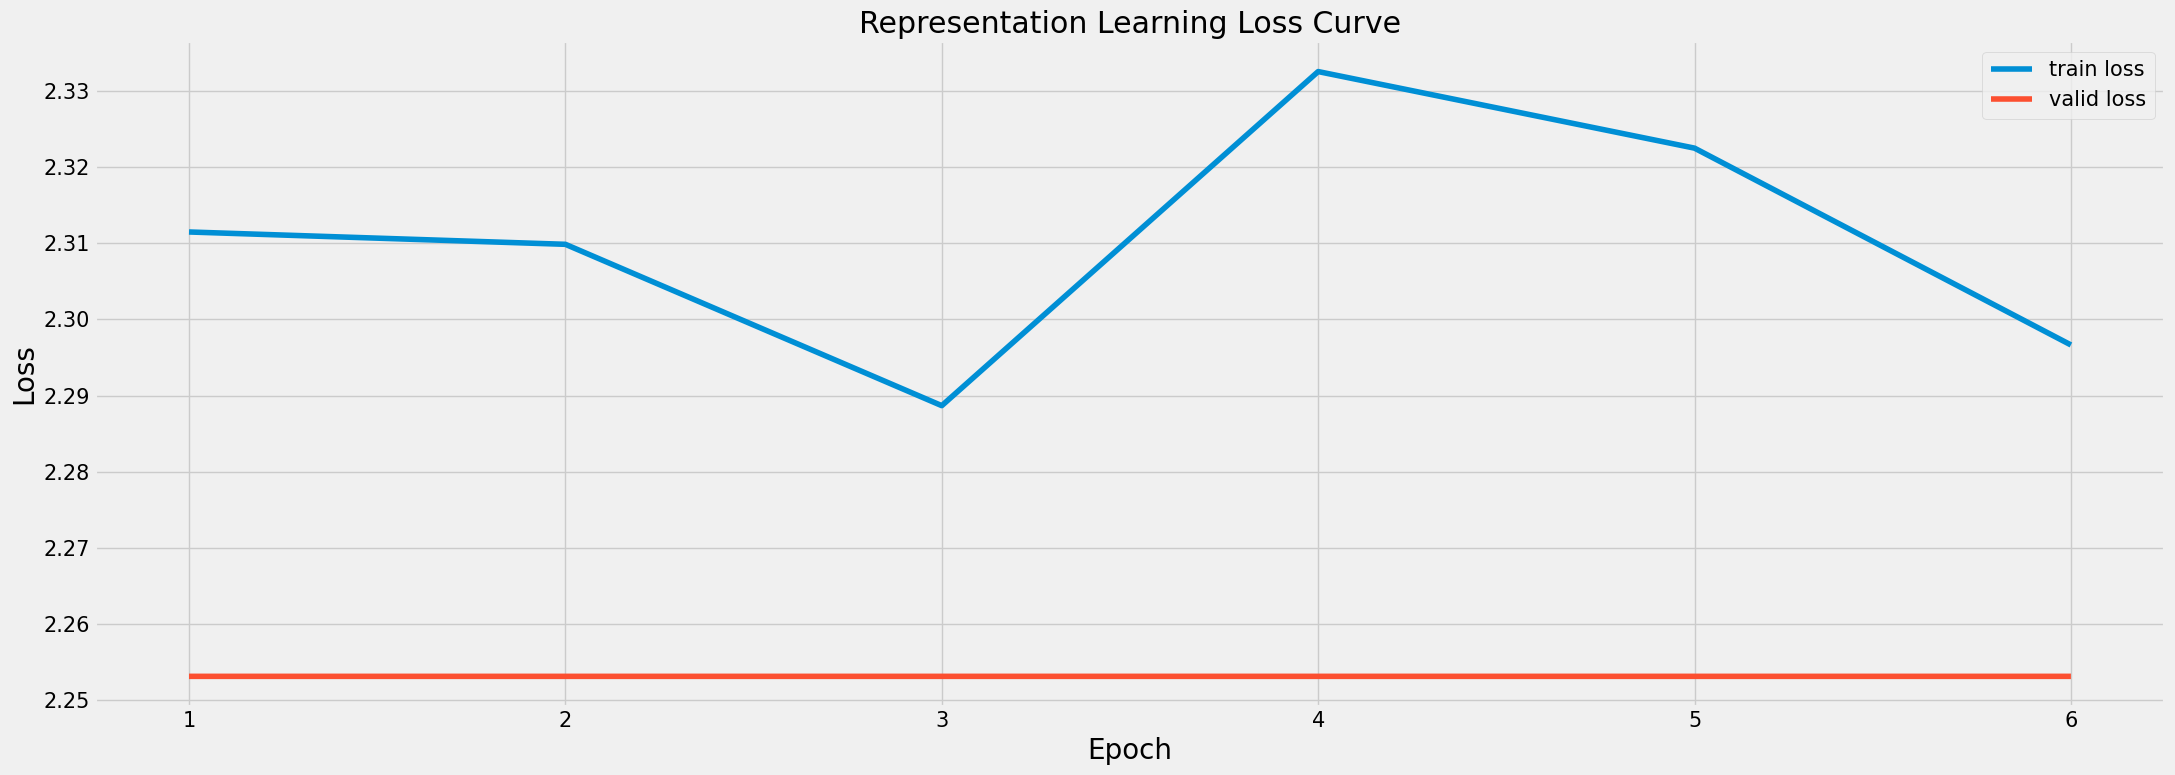

In [26]:
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = "15"

fig = plt.figure(figsize=(22, 8))
epochs = list(range(1, len(rep_history["train_loss"]) + 1))

plt.plot(epochs, rep_history["train_loss"], label="train loss")
plt.plot(epochs, rep_history["val_loss"], label="valid loss")
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.legend()
plt.title("Representation Learning Loss Curve")

plt.tight_layout()
plt.show()

In [21]:
# Stage 2: Classification with Multimodal Fusion
print("Stage 2: Classification with Multimodal Fusion")
criterion_clf = nn.CrossEntropyLoss()
optimizer_clf = torch.optim.Adam(vit_model.parameters(), lr=0.001, weight_decay=0.01)
# scheduler_rep = lr_scheduler.CosineAnnealingLR(optimizer_rep, T_max=20, eta_min=0)
scheduler_clf = lr_scheduler.StepLR(optimizer_rep, step_size=7, gamma=0.1)

vit_model, clf_history = train_classifier(
    vit_model,
    criterion_clf,
    optimizer_clf,
    scheduler_clf,
    num_epochs=20,
    dataloaders=dataloaders_re,
    device=device,
    patience=5,
    save_path="best_clf_model.pth",
)

# Print training results
print("Training completed.")
print("Representation Learning:")
print(f"Final training loss: {rep_history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {rep_history['val_loss'][-1]:.4f}")
print("Classification:")
print(f"Final training loss: {clf_history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {clf_history['val_loss'][-1]:.4f}")
print(f"Final training accuracy: {clf_history['train_acc'][-1]:.4f}")
print(f"Final validation accuracy: {clf_history['val_acc'][-1]:.4f}")

Stage 2: Classification with Multimodal Fusion
Epoch 1/20
----------
Train Loss: 2.3754 Acc: 0.3978
Val Loss: 1.3137 Acc: 0.3719
Saved best model to best_clf_model.pth
Epoch 2/20
----------
Train Loss: 1.1484 Acc: 0.5166
Val Loss: 1.1931 Acc: 0.4463
Saved best model to best_clf_model.pth
Epoch 3/20
----------
Train Loss: 1.0105 Acc: 0.5746
Val Loss: 1.2059 Acc: 0.4793
Epoch 4/20
----------
Train Loss: 0.9573 Acc: 0.5856
Val Loss: 1.2753 Acc: 0.4298
Epoch 5/20
----------
Train Loss: 0.8845 Acc: 0.6354
Val Loss: 1.3219 Acc: 0.4380
Epoch 6/20
----------
Train Loss: 0.7874 Acc: 0.6768
Val Loss: 1.3155 Acc: 0.4628
Epoch 7/20
----------
Train Loss: 0.7669 Acc: 0.6878
Val Loss: 1.2790 Acc: 0.4545
Early stopping after 7 epochs
Training complete in 0h 43m 37s
Best Loss: 1.193120605689435
Training completed.
Representation Learning:
Final training loss: 2.2967
Final validation loss: 2.2532
Classification:
Final training loss: 0.7669
Final validation loss: 1.2790
Final training accuracy: 0.6878
F

In [35]:

# MODEL 2
import torch
import torch.nn as nn
import timm
from torch.optim import lr_scheduler, AdamW
from collections import defaultdict
from time import time
import importlib
import model.ViTrainer

importlib.reload(model.ViTrainer)
from model.ViTrainer import (
    VisionTransformerMLP,
    train_representation,
    train_classifier,
)
import sys

# Stage 2: Classification with Multimodal Fusion
print("Stage 2: Classification with Multimodal Fusion")
criterion_clf = FocalLoss()
optimizer_clf =torch.optim.Adam(vit_model.parameters(), lr=1e-3, weight_decay=1e-5)
# scheduler_clf = lr_scheduler.CosineAnnealingLR(optimizer_clf, T_max=20, eta_min=0)
scheduler_clf = lr_scheduler.StepLR(optimizer_clf, step_size=7, gamma=0.1)

vit_model, clf_history = train_classifier(
    vit_model,
    criterion_clf,
    optimizer_clf,
    scheduler_clf,
    num_epochs=15,
    dataloaders=dataloaders_re,
    device=device,
    save_path="best_clf_model2.pth",
)

# Print training results
print("Training completed.")
print("Representation Learning:")
print(f"Final training loss: {rep_history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {rep_history['val_loss'][-1]:.4f}")
print("Classification:")
print(f"Final training loss: {clf_history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {clf_history['val_loss'][-1]:.4f}")
print(f"Final training accuracy: {clf_history['train_acc'][-1]:.4f}")
print(f"Final validation accuracy: {clf_history['val_acc'][-1]:.4f}")

Stage 2: Classification with Multimodal Fusion
Epoch 1/15
----------
Train Loss: 1.1485 Acc: 0.3812
Val Loss: 0.7345 Acc: 0.4298
Saved best model to best_clf_model2.pth
Epoch 2/15
----------
Train Loss: 0.3722 Acc: 0.5138
Val Loss: 0.5746 Acc: 0.4298
Saved best model to best_clf_model2.pth
Epoch 3/15
----------
Train Loss: 0.2762 Acc: 0.6077
Val Loss: 0.6593 Acc: 0.3884
Epoch 4/15
----------
Train Loss: 0.2401 Acc: 0.6436
Val Loss: 0.9238 Acc: 0.4298
Epoch 5/15
----------
Train Loss: 0.9459 Acc: 0.5470
Val Loss: 2.4714 Acc: 0.3967
Epoch 6/15
----------
Train Loss: 0.4909 Acc: 0.6077
Val Loss: 0.9586 Acc: 0.4380
Epoch 7/15
----------
Train Loss: 0.2476 Acc: 0.6934
Val Loss: 1.4204 Acc: 0.3719
Epoch 8/15
----------
Train Loss: 0.2069 Acc: 0.6851
Val Loss: 1.0387 Acc: 0.3802
Epoch 9/15
----------
Train Loss: 0.1455 Acc: 0.7182
Val Loss: 1.2048 Acc: 0.4380
Epoch 10/15
----------
Train Loss: 0.1029 Acc: 0.7514
Val Loss: 1.1880 Acc: 0.4215
Epoch 11/15
----------
Train Loss: 0.0961 Acc: 0.748

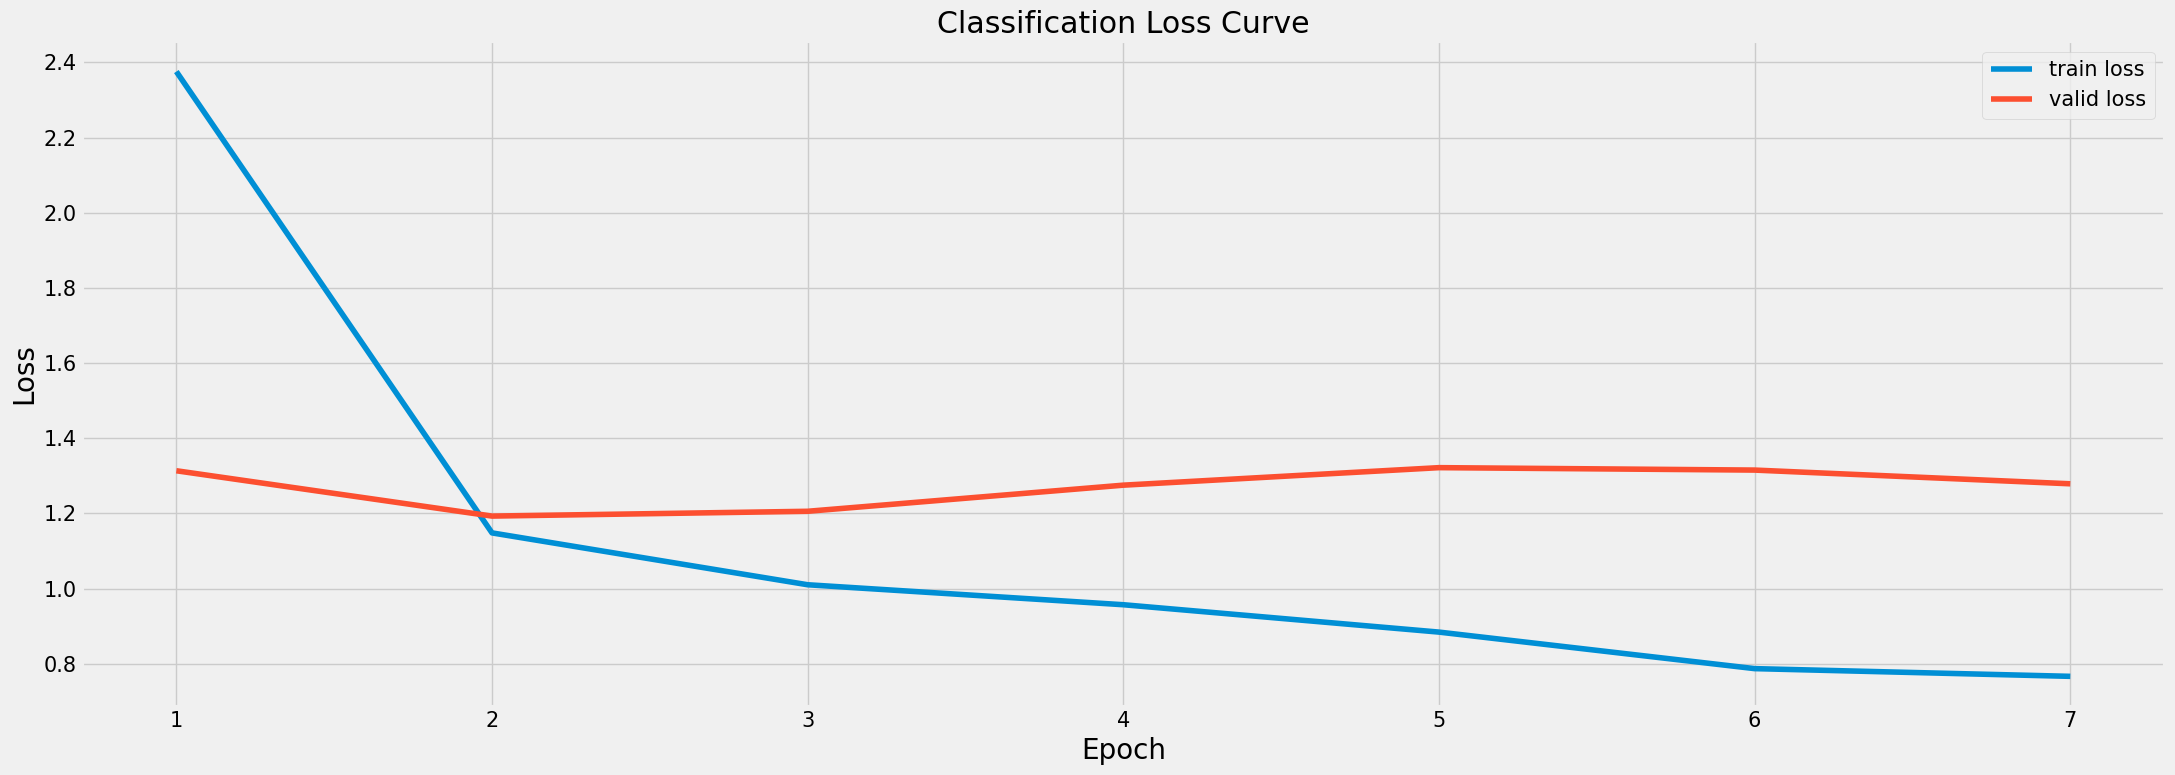

In [27]:
fig = plt.figure(figsize=(22, 8))
epochs = list(range(1, len(clf_history["train_loss"]) + 1))

plt.plot(epochs, clf_history["train_loss"], label="train loss")
plt.plot(epochs, clf_history["val_loss"], label="valid loss")
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.legend()
plt.title("Classification Loss Curve")

plt.tight_layout()
plt.show()

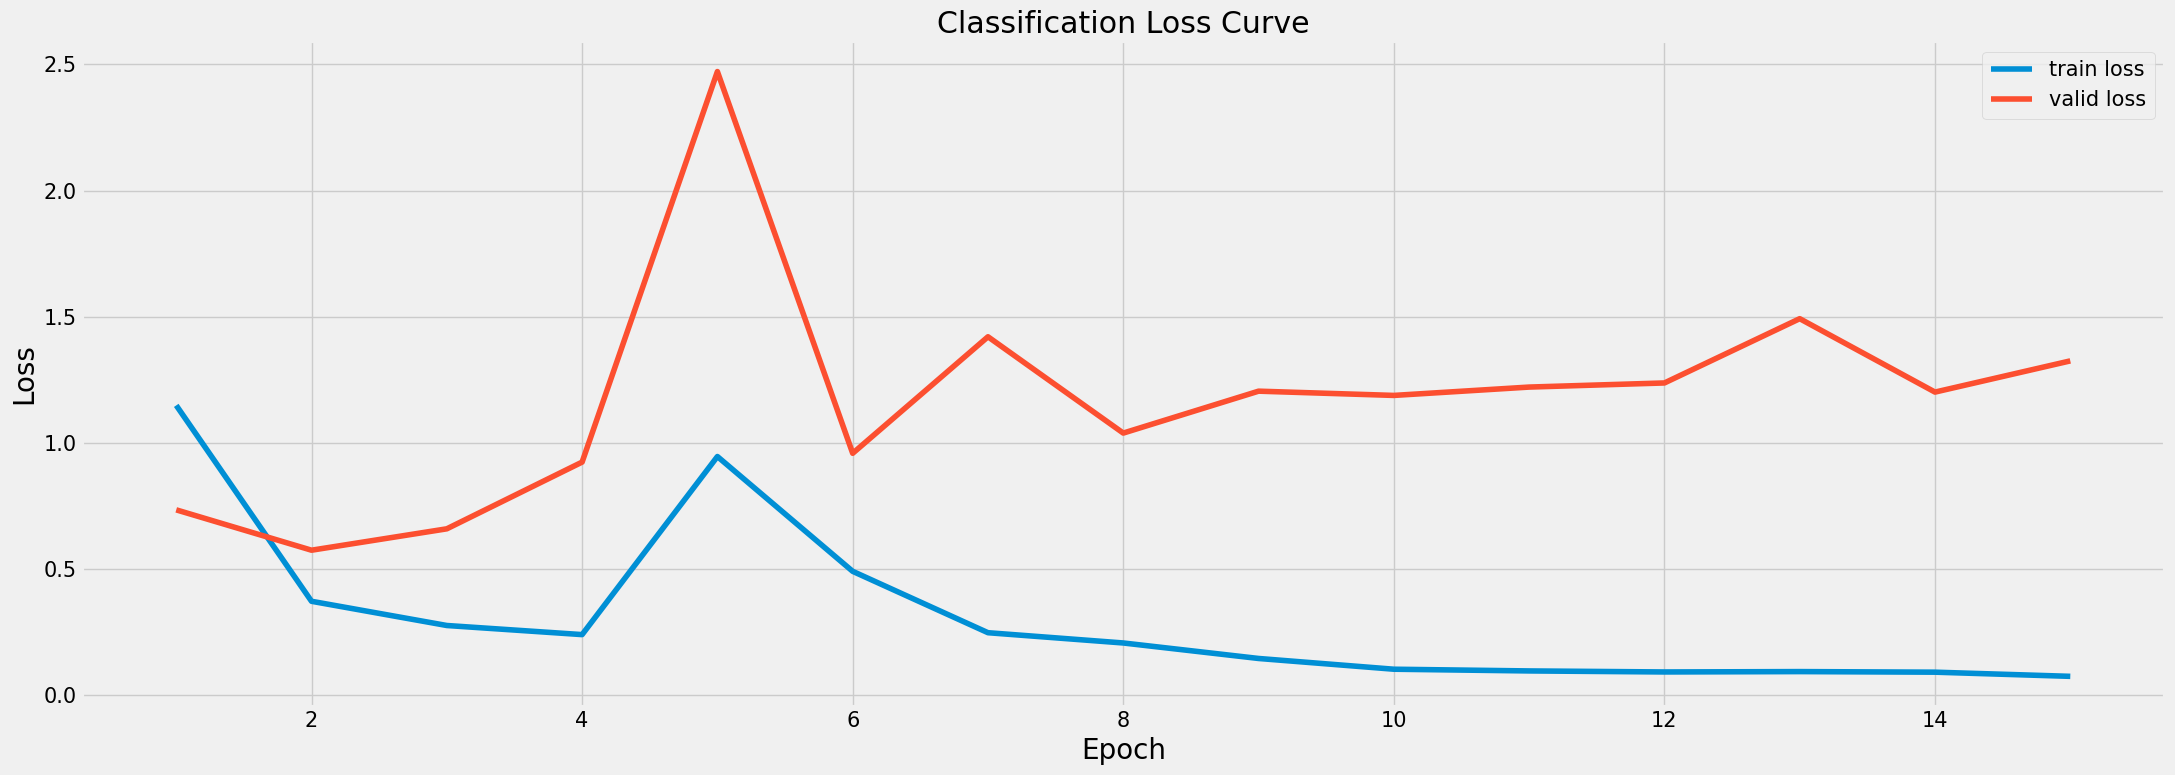

In [36]:
fig = plt.figure(figsize=(22, 8))
epochs = list(range(1, len(clf_history["train_loss"]) + 1))

plt.plot(epochs, clf_history["train_loss"], label="train loss")
plt.plot(epochs, clf_history["val_loss"], label="valid loss")
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.legend()
plt.title("Classification Loss Curve")

plt.tight_layout()
plt.show()

In [19]:
criterion_class = FocalLoss()
criterion_seg = DiceLoss()

In [20]:
# dataset_sizes = {'train':len(train_df), 'val':len(val_df)}

# def train_model(model, optimizer, scheduler, num_epochs=25):
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch+1, num_epochs))
#         print('-' * 10)

#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()
#             else:
#                 model.eval()  

#             running_loss = 0.0
#             running_acc_seg = 0.0
#             running_acc_class = 0.0

#             for images, seg, slope, labels in dataloaders[phase]:
#                 images = images.to(device)
#                 seg = seg.to(device)
#                 slope = slope.to(device)
#                 labels = labels.to(device)

#                 optimizer.zero_grad()

#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs, out_class = model(images, slope)
#                     loss_seg = criterion_seg(outputs, torch.unsqueeze(seg.float(), dim=1))
#                     loss_class = criterion_class(out_class, labels)
#                     loss = loss_seg + loss_class

#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 m1, m0, m_avg = get_acc_binseg(outputs, torch.unsqueeze(seg.float(), dim=1))
#                 running_acc_seg += m_avg.item()
#                 running_acc_class += get_acc_class(out_class, labels).item()
#                 running_loss += loss.item()
                
#             epoch_loss = running_loss / len(dataloaders[phase])
#             epoch_acc_seg = running_acc_seg / len(dataloaders[phase])
#             epoch_acc_class = running_acc_class / len(dataloaders[phase])

#             print('{} Loss: {:.4f} Acc Seg: {:.4f} Acc Class: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc_seg, epoch_acc_class))
#             acc_seg_dict[phase].append(epoch_acc_seg)
#             acc_class_dict[phase].append(epoch_acc_class)
#             loss_dict[phase].append(epoch_loss)

#             if phase == 'val' and epoch_acc_class > best_acc:
#                 best_acc = epoch_acc_class
#                 best_model_wts = copy.deepcopy(model.state_dict())

#     print('Best val Acc: {:4f}'.format(best_acc))

#     model.load_state_dict(best_model_wts)
#     return model

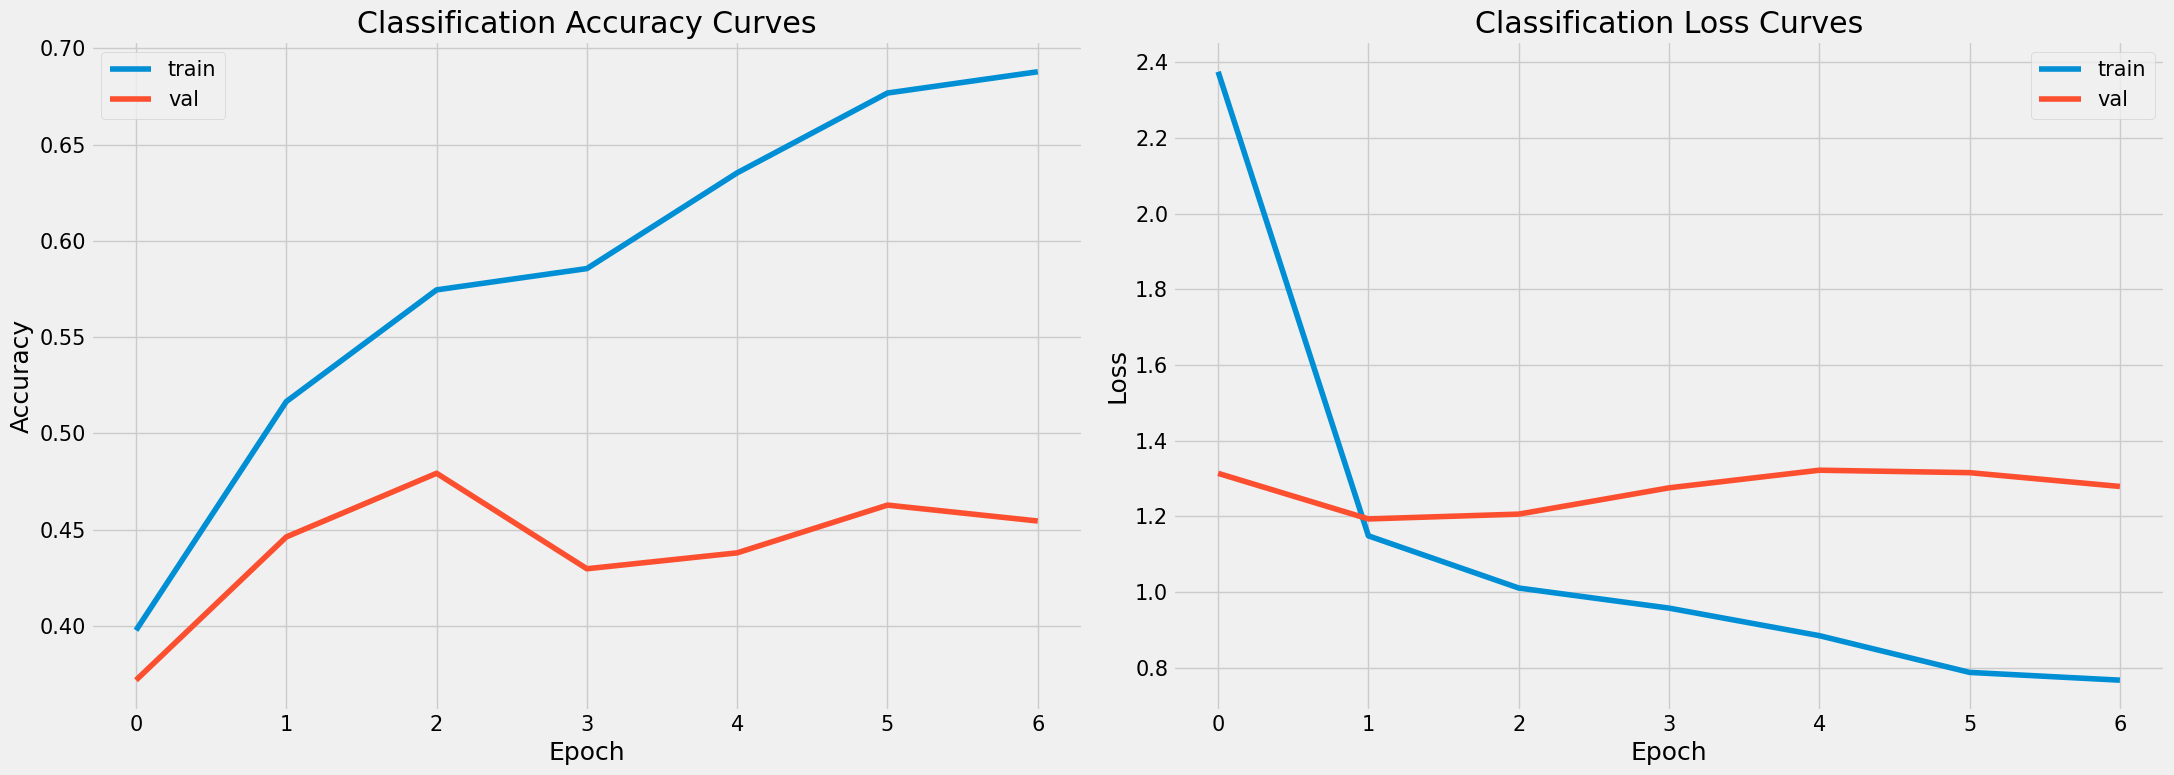

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def show_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

    # Accuracy plot
    ax1.plot(history["train_acc"], label="train")
    ax1.plot(history["val_acc"], label="val")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Classification Accuracy Curves")
    ax1.legend()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Loss plot
    ax2.plot(history["train_loss"], label="train")
    ax2.plot(history["val_loss"], label="val")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.set_title("Classification Loss Curves")
    ax2.legend()
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()


# After training the classifier, you can call this function:
show_curves(clf_history)




## MODEL 2

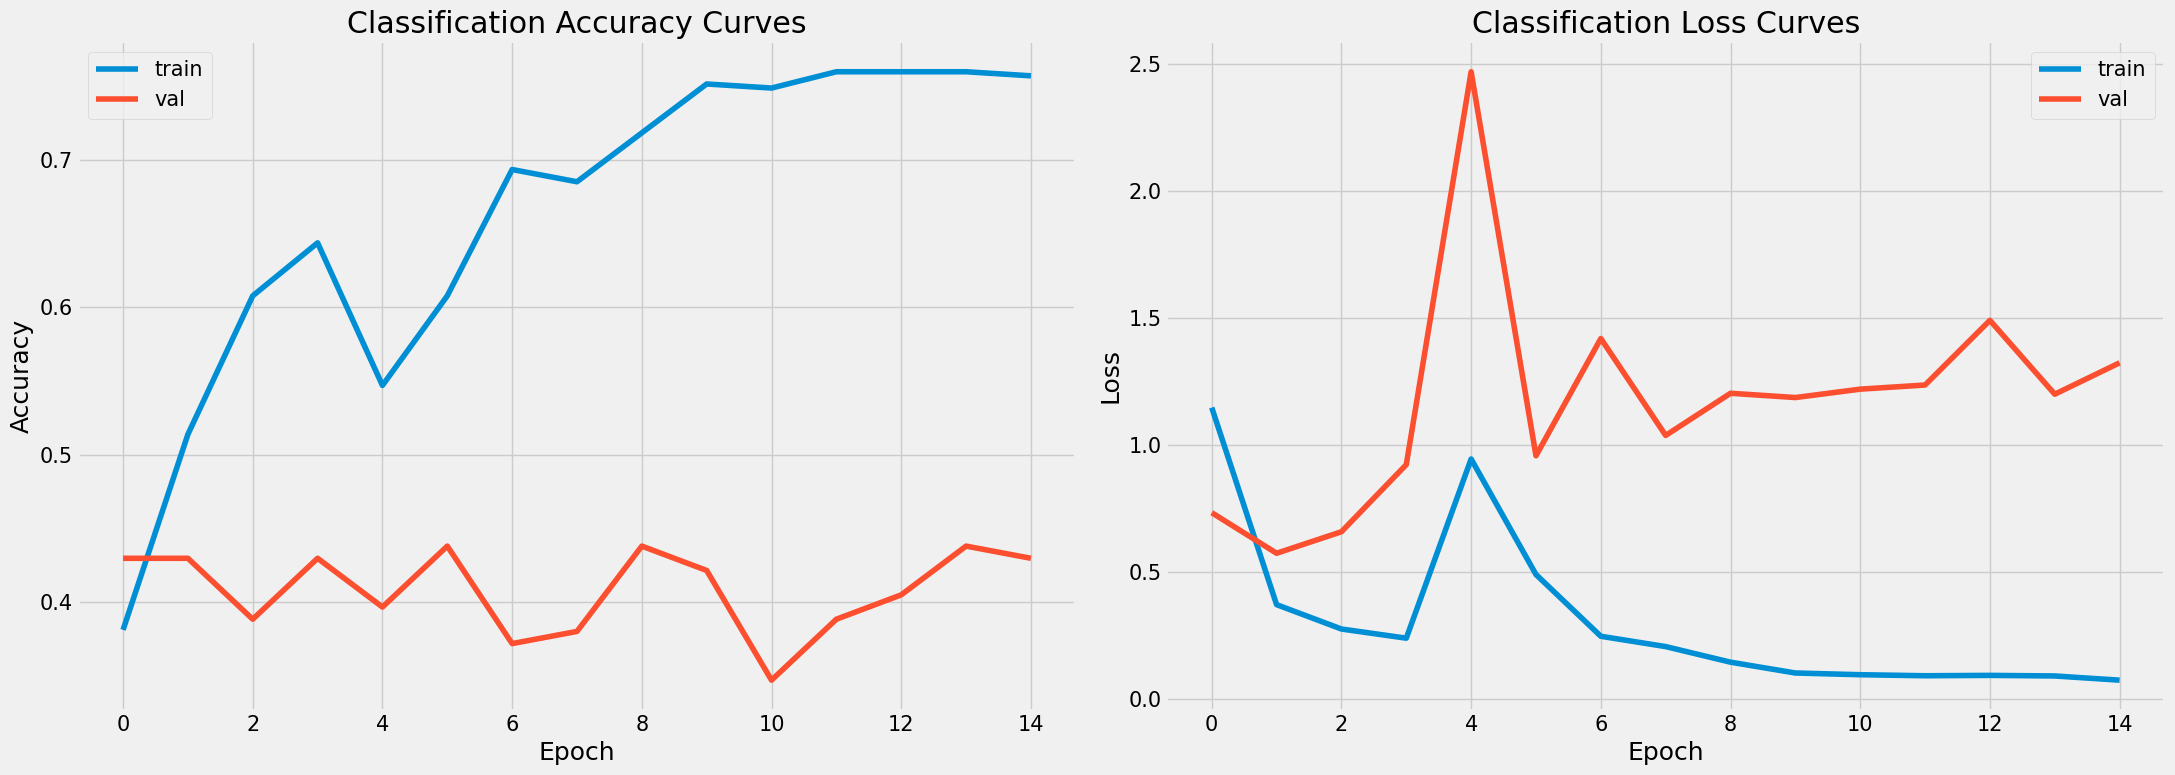

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def show_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

    # Accuracy plot
    ax1.plot(history["train_acc"], label="train")
    ax1.plot(history["val_acc"], label="val")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Classification Accuracy Curves")
    ax1.legend()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Loss plot
    ax2.plot(history["train_loss"], label="train")
    ax2.plot(history["val_loss"], label="val")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.set_title("Classification Loss Curves")
    ax2.legend()
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()


# After training the classifier, you can call this function:
show_curves(clf_history)

In [31]:
def test(model, testloader, device):
    model.eval()
    running_accuracy = 0
    total = 0

    with torch.no_grad():
        for images, seg, slope, labels in testloader:
            images = images.float().to(device)
            seg = seg.float().to(device)
            slope = slope.float().to(device)
            labels = labels.to(device)

            outputs = model(images, slope)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            running_accuracy += (predicted == labels).sum().item()

    accuracy = 100 * running_accuracy / total
    print(f"Accuracy of the model based on the test set is: {accuracy:.2f}%")
    return accuracy




In [32]:
test_accuracy = test(vit_model, testloader, device)

Accuracy of the model based on the test set is: 41.61%


## MODEL 2


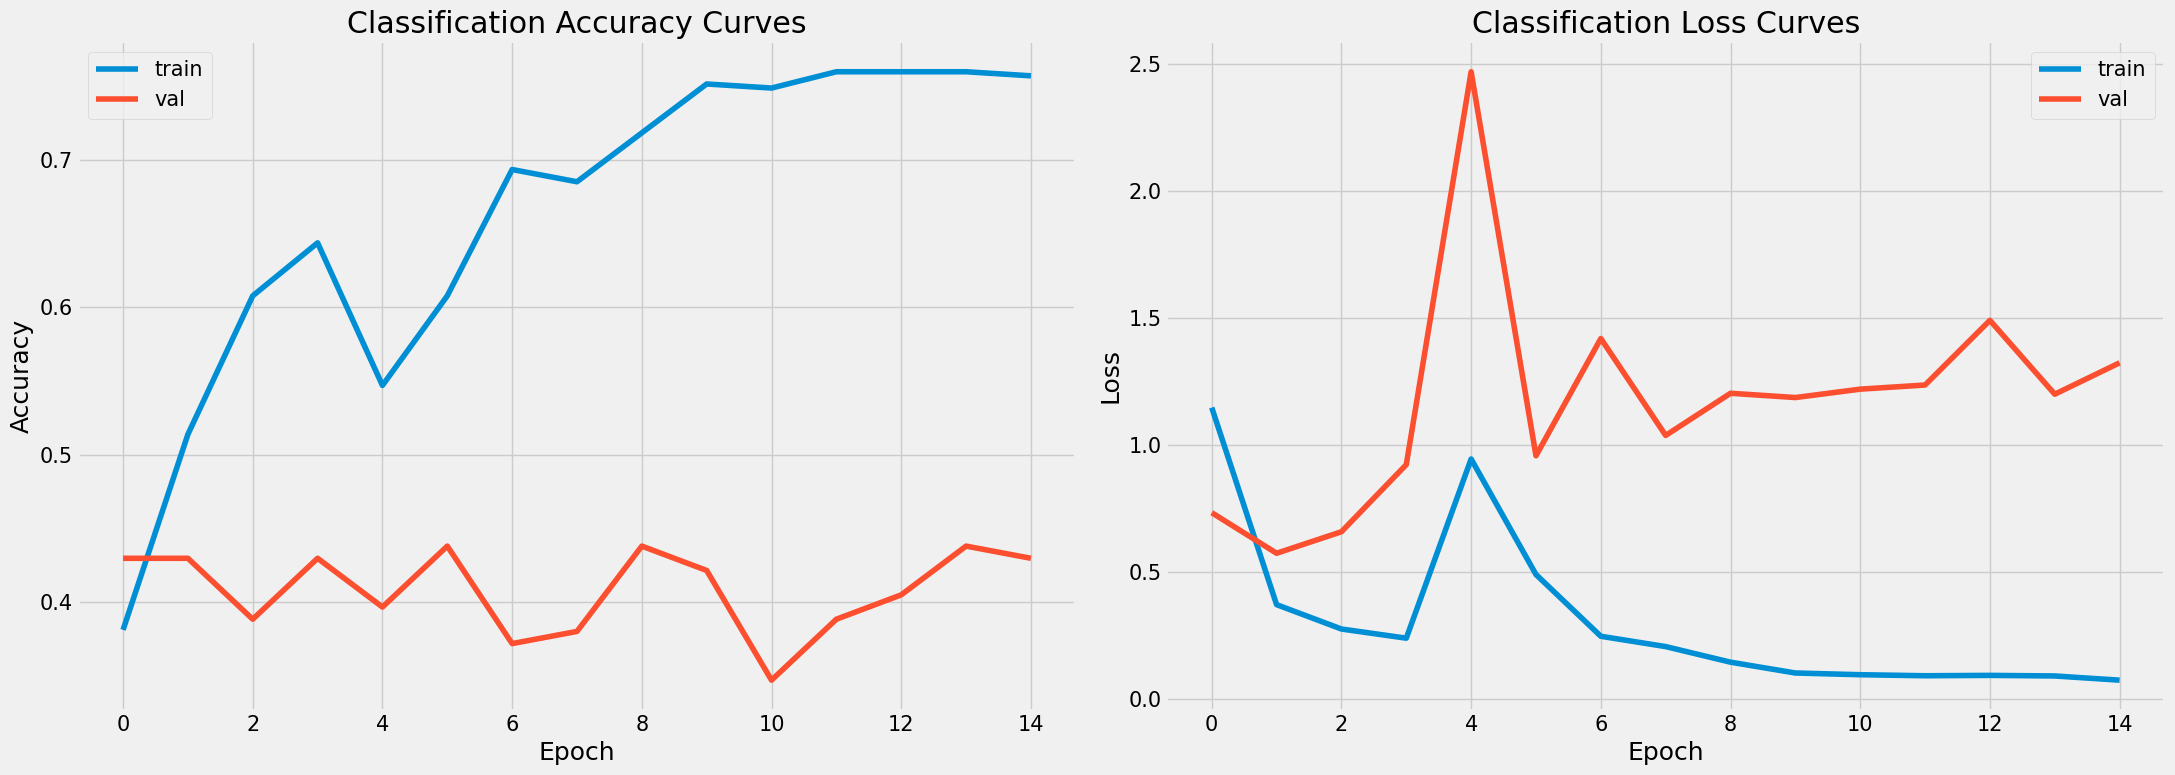

In [38]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def show_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

    # Accuracy plot
    ax1.plot(history["train_acc"], label="train")
    ax1.plot(history["val_acc"], label="val")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Classification Accuracy Curves")
    ax1.legend()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Loss plot
    ax2.plot(history["train_loss"], label="train")
    ax2.plot(history["val_loss"], label="val")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.set_title("Classification Loss Curves")
    ax2.legend()
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()


# After training the classifier, you can call this function:
show_curves(clf_history)

In [39]:
def test(model, testloader, device):
    model.eval()
    running_accuracy = 0
    total = 0

    with torch.no_grad():
        for images, seg, slope, labels in testloader:
            images = images.float().to(device)
            seg = seg.float().to(device)
            slope = slope.float().to(device)
            labels = labels.to(device)

            outputs = model(images, slope)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            running_accuracy += (predicted == labels).sum().item()

    accuracy = 100 * running_accuracy / total
    print(f"Accuracy of the model based on the test set is: {accuracy:.2f}%")
    return accuracy

In [40]:
test_accuracy = test(vit_model, testloader, device)

Accuracy of the model based on the test set is: 48.32%


# MODEL 3 - 32 PATCHES

In [41]:
import torch
import torch.nn as nn
import timm
from torch.optim import lr_scheduler, AdamW
from collections import defaultdict
from time import time
import importlib
import model.ViTrainer

importlib.reload(model.ViTrainer)
from model.ViTrainer import (
    VisionTransformerMLP,
    train_representation,
    train_classifier,
)
import sys

# Create the VisionTransformerMLP model
vit_model = VisionTransformerMLP(
    model_name="vit_base_patch32_224",
    num_classes=4,
    dropout=0.1,
    img_size=160,
    dataset_size=len(train_dataset),
)
vit_model = vit_model.to(device)

# Stage 1: Representation Learning
print("Stage 1: Representation Learning")
criterion_rep = SupervisedContrastiveLoss()
optimizer_rep = torch.optim.Adam(vit_model.parameters(), lr=0.001, weight_decay=0.01)
# scheduler_rep = lr_scheduler.CosineAnnealingLR(optimizer_rep, T_max=20, eta_min=0)
scheduler_rep = lr_scheduler.StepLR(optimizer_rep, step_size=7, gamma=0.1)

vit_model, rep_history = train_representation(
    vit_model,
    criterion_rep,
    optimizer_rep,
    scheduler_rep,
    num_epochs=20,
    dataloaders=dataloaders_re,
    device=device,
)

Stage 1: Representation Learning
Epoch 1/20
----------
Train Loss: 2.2782
Val Loss: 2.2532
Epoch 2/20
----------
Train Loss: 2.3403
Val Loss: 2.2532
Epoch 3/20
----------
Train Loss: 2.3229
Val Loss: 2.2532
Epoch 4/20
----------
Train Loss: 2.3180
Val Loss: 2.2532
Epoch 5/20
----------
Train Loss: 2.2658
Val Loss: 2.2532
Epoch 6/20
----------
Train Loss: 2.2851
Val Loss: 2.2532
Epoch 7/20
----------
Train Loss: 2.3174
Val Loss: 2.2532
Epoch 8/20
----------
Train Loss: 2.3111
Val Loss: 2.2532
Epoch 9/20
----------
Train Loss: 2.2532
Val Loss: 2.2532
Epoch 10/20
----------
Train Loss: 2.3023
Val Loss: 2.2532
Epoch 11/20
----------
Train Loss: 2.3405
Val Loss: 2.2532
Epoch 12/20
----------
Train Loss: 2.3192
Val Loss: 2.2532
Epoch 13/20
----------
Train Loss: 2.3508
Val Loss: 2.2532
Epoch 14/20
----------
Train Loss: 2.3058
Val Loss: 2.2532
Epoch 15/20
----------
Train Loss: 2.2375
Val Loss: 2.2532
Epoch 16/20
----------
Train Loss: 2.2479
Val Loss: 2.2532
Epoch 17/20
----------
Train Los

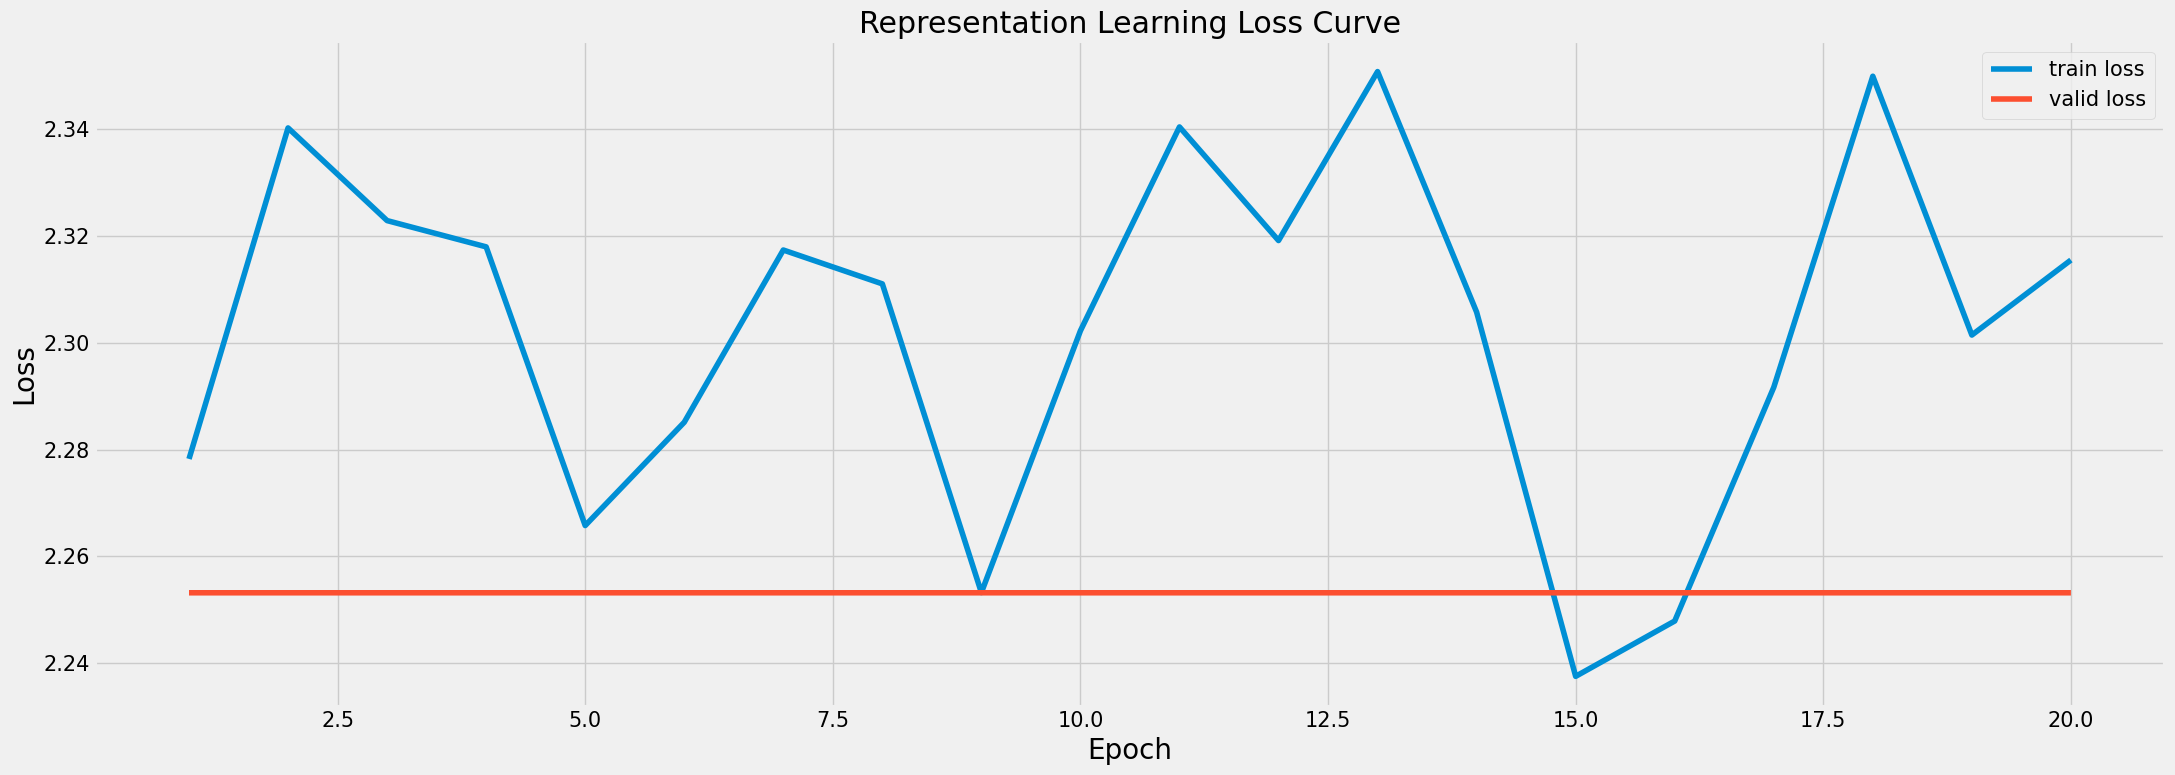

In [42]:
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = "15"

fig = plt.figure(figsize=(22, 8))
epochs = list(range(1, len(rep_history["train_loss"]) + 1))

plt.plot(epochs, rep_history["train_loss"], label="train loss")
plt.plot(epochs, rep_history["val_loss"], label="valid loss")
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.legend()
plt.title("Representation Learning Loss Curve")

plt.tight_layout()
plt.show()

In [43]:
# MODEL 2
import torch
import torch.nn as nn
import timm
from torch.optim import lr_scheduler, AdamW
from collections import defaultdict
from time import time
import importlib
import model.ViTrainer

importlib.reload(model.ViTrainer)
from model.ViTrainer import (
    VisionTransformerMLP,
    train_representation,
    train_classifier,
)
import sys

# Stage 2: Classification with Multimodal Fusion
print("Stage 2: Classification with Multimodal Fusion")
criterion_clf = FocalLoss()
optimizer_clf = torch.optim.Adam(vit_model.parameters(), lr=1e-3, weight_decay=1e-5)
# scheduler_clf = lr_scheduler.CosineAnnealingLR(optimizer_clf, T_max=20, eta_min=0)
scheduler_clf = lr_scheduler.StepLR(optimizer_clf, step_size=7, gamma=0.1)

vit_model, clf_history = train_classifier(
    vit_model,
    criterion_clf,
    optimizer_clf,
    scheduler_clf,
    num_epochs=15,
    dataloaders=dataloaders_re,
    device=device,
    save_path="best_clf_model_32patches.pth",
)

# Print training results
print("Training completed.")
print("Representation Learning:")
print(f"Final training loss: {rep_history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {rep_history['val_loss'][-1]:.4f}")
print("Classification:")
print(f"Final training loss: {clf_history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {clf_history['val_loss'][-1]:.4f}")
print(f"Final training accuracy: {clf_history['train_acc'][-1]:.4f}")
print(f"Final validation accuracy: {clf_history['val_acc'][-1]:.4f}")

Stage 2: Classification with Multimodal Fusion
Epoch 1/15
----------
Train Loss: 0.8228 Acc: 0.4033
Val Loss: 0.5549 Acc: 0.4298
Saved best model to best_clf_model_32patches.pth
Epoch 2/15
----------
Train Loss: 0.4504 Acc: 0.4945
Val Loss: 0.6063 Acc: 0.4298
Epoch 3/15
----------
Train Loss: 0.3792 Acc: 0.5110
Val Loss: 0.5085 Acc: 0.4959
Saved best model to best_clf_model_32patches.pth
Epoch 4/15
----------
Train Loss: 0.3362 Acc: 0.5663
Val Loss: 0.7463 Acc: 0.4711
Epoch 5/15
----------
Train Loss: 0.2368 Acc: 0.6188
Val Loss: 0.6703 Acc: 0.4628
Epoch 6/15
----------
Train Loss: 0.1967 Acc: 0.6657
Val Loss: 0.6965 Acc: 0.4545
Epoch 7/15
----------
Train Loss: 0.1515 Acc: 0.6934
Val Loss: 0.6619 Acc: 0.4215
Epoch 8/15
----------
Train Loss: 0.1411 Acc: 0.7514
Val Loss: 0.8790 Acc: 0.3223
Epoch 9/15
----------
Train Loss: 0.1524 Acc: 0.6878
Val Loss: 0.8464 Acc: 0.3967
Epoch 10/15
----------
Train Loss: 0.1389 Acc: 0.6961
Val Loss: 0.8356 Acc: 0.4132
Epoch 11/15
----------
Train Loss:

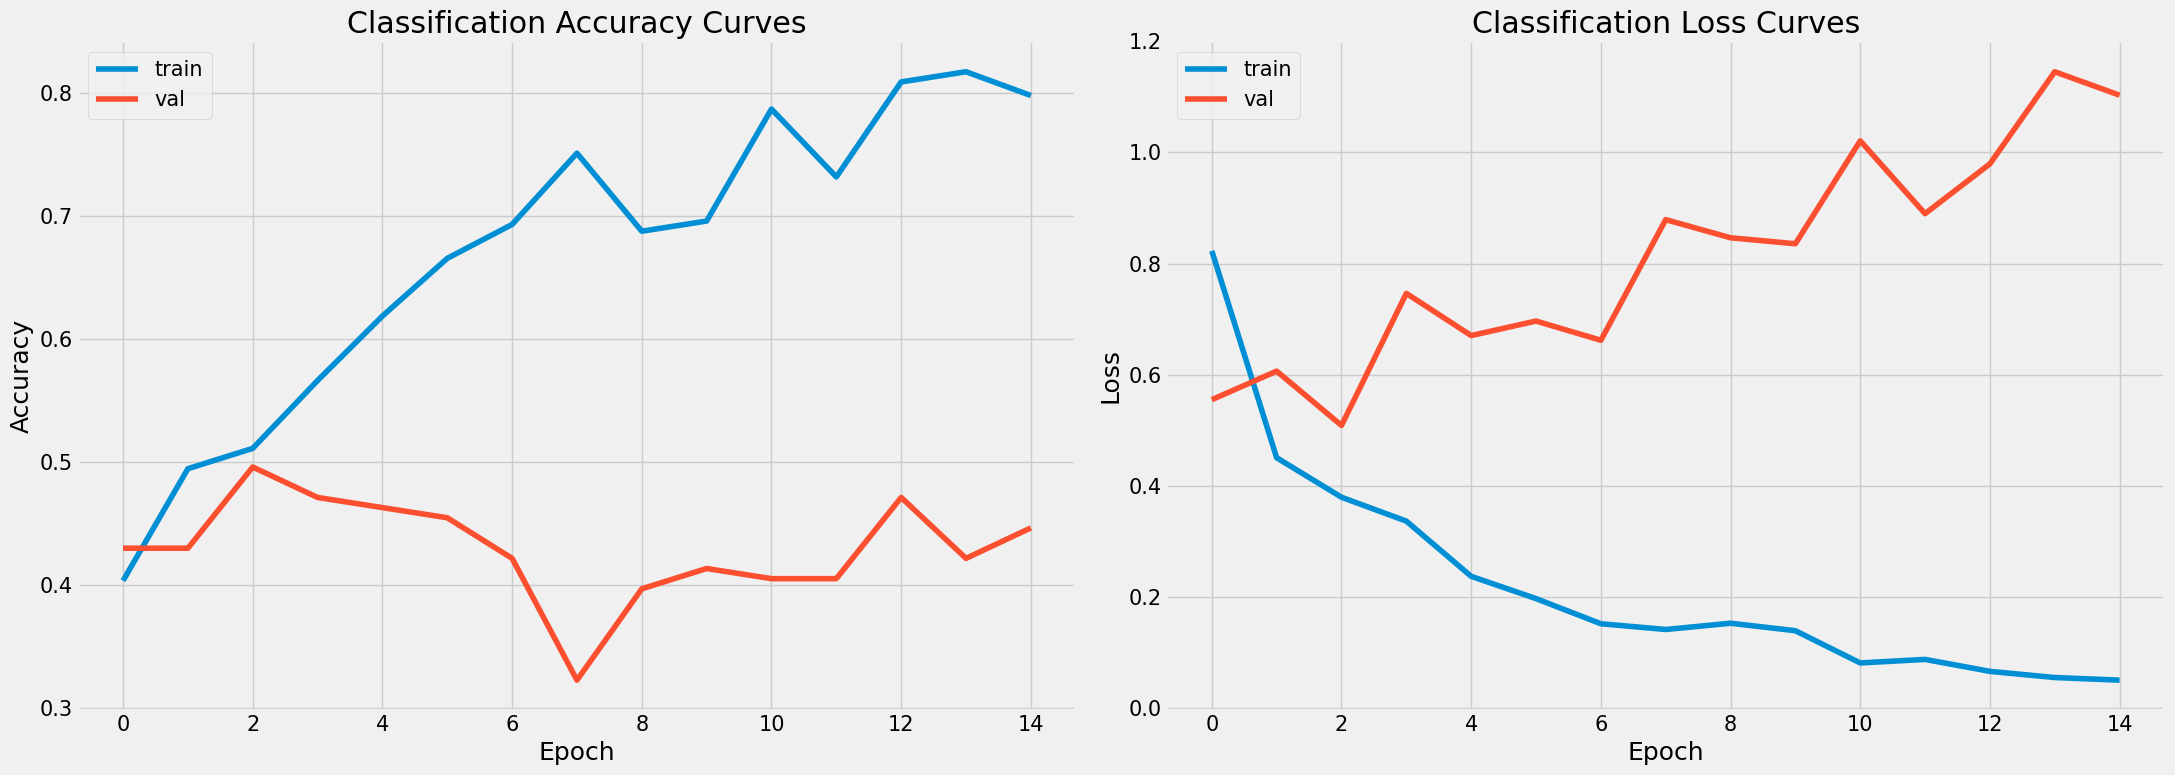

In [44]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def show_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

    # Accuracy plot
    ax1.plot(history["train_acc"], label="train")
    ax1.plot(history["val_acc"], label="val")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Classification Accuracy Curves")
    ax1.legend()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Loss plot
    ax2.plot(history["train_loss"], label="train")
    ax2.plot(history["val_loss"], label="val")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.set_title("Classification Loss Curves")
    ax2.legend()
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()


# After training the classifier, you can call this function:
show_curves(clf_history)

In [45]:
def test(model, testloader, device):
    model.eval()
    running_accuracy = 0
    total = 0

    with torch.no_grad():
        for images, seg, slope, labels in testloader:
            images = images.float().to(device)
            seg = seg.float().to(device)
            slope = slope.float().to(device)
            labels = labels.to(device)

            outputs = model(images, slope)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            running_accuracy += (predicted == labels).sum().item()

    accuracy = 100 * running_accuracy / total
    print(f"Accuracy of the model based on the test set is: {accuracy:.2f}%")
    return accuracy

In [46]:
test_accuracy = test(vit_model, testloader, device)

Accuracy of the model based on the test set is: 44.97%


# MODEL 4

In [76]:
# Create the VisionTransformerMLP model
import torch
import torch.nn as nn
import timm
from torch.optim import lr_scheduler, AdamW
from collections import defaultdict
from time import time
import importlib
import model.ViTrainer

importlib.reload(model.ViTrainer)
from model.ViTrainer import (
    VisionTransformerMLP,
    train_representation,
    train_classifier,
)
import sys
vit_model = VisionTransformerMLP(
    model_name="vit_base_patch16_224",
    num_classes=4,
    dropout=0.1,
    img_size=160,
    dataset_size=len(train_dataset),
)
vit_model = vit_model.to(device)

# Stage 1: Representation Learning
print("Stage 1: Representation Learning")
criterion_rep = SupervisedContrastiveLoss()
optimizer_rep = AdamW(vit_model.parameters(), lr=0.001, weight_decay=0.01)
scheduler_rep = lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_rep, T_0=10, T_mult=2, eta_min=1e-6
)

vit_model, rep_history = train_representation(
    vit_model,
    criterion_rep,
    optimizer_rep,
    scheduler_rep,
    num_epochs=20,
    dataloaders=dataloaders_re,
    device=device,
    )
        

Stage 1: Representation Learning
Epoch 1/20
----------
Train Loss: 2.2987
Val Loss: 2.2532
Epoch 2/20
----------
Train Loss: 2.2570
Val Loss: 2.2532
Epoch 3/20
----------
Train Loss: 2.2725
Val Loss: 2.2532
Epoch 4/20
----------
Train Loss: 2.3056
Val Loss: 2.2532
Epoch 5/20
----------
Train Loss: 2.2845
Val Loss: 2.2532
Epoch 6/20
----------
Train Loss: 2.3143
Val Loss: 2.2532
Epoch 7/20
----------
Train Loss: 2.2679
Val Loss: 2.2532
Epoch 8/20
----------
Train Loss: 2.2952
Val Loss: 2.2532
Epoch 9/20
----------
Train Loss: 2.2981
Val Loss: 2.2532
Epoch 10/20
----------
Train Loss: 2.3220
Val Loss: 2.2532
Epoch 11/20
----------
Train Loss: 2.3102
Val Loss: 2.2532
Epoch 12/20
----------
Train Loss: 2.3146
Val Loss: 2.2532
Epoch 13/20
----------
Train Loss: 2.2819
Val Loss: 2.2532
Epoch 14/20
----------
Train Loss: 2.2915
Val Loss: 2.2532
Epoch 15/20
----------
Train Loss: 2.3006
Val Loss: 2.2532
Epoch 16/20
----------
Train Loss: 2.2725
Val Loss: 2.2532
Epoch 17/20
----------
Train Los

In [77]:
# Stage 2: Classification with Multimodal Fusion
print("Stage 2: Classification with Multimodal Fusion")
criterion_clf = FocalLoss()
optimizer_clf = AdamW(vit_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_clf = lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_clf, T_0=10, T_mult=2, eta_min=1e-6
)

vit_model, clf_history = train_classifier(
    vit_model,
    criterion_clf,
    optimizer_clf,
    scheduler_clf,
    num_epochs=15,
    dataloaders=dataloaders_re,
    device=device,
    save_path="best_clf_model_16patches_optimized.pth",
)

# Print training results
print("Training completed.")
print("Representation Learning:")
print(f"Final training loss: {rep_history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {rep_history['val_loss'][-1]:.4f}")
print("Classification:")
print(f"Final training loss: {clf_history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {clf_history['val_loss'][-1]:.4f}")
print(f"Final training accuracy: {clf_history['train_acc'][-1]:.4f}")
print(f"Final validation accuracy: {clf_history['val_acc'][-1]:.4f}")

Stage 2: Classification with Multimodal Fusion
Epoch 1/15
----------
Train Loss: 2.5028 Acc: 0.3757
Val Loss: 0.6449 Acc: 0.4876
Saved best model to best_clf_model_16patches_optimized.pth
Epoch 2/15
----------
Train Loss: 0.6268 Acc: 0.4171
Val Loss: 0.5730 Acc: 0.4628
Saved best model to best_clf_model_16patches_optimized.pth
Epoch 3/15
----------
Train Loss: 0.4270 Acc: 0.4972
Val Loss: 0.5845 Acc: 0.4380
Epoch 4/15
----------
Train Loss: 0.3181 Acc: 0.5746
Val Loss: 0.8990 Acc: 0.4711
Epoch 5/15
----------
Train Loss: 0.3413 Acc: 0.5552
Val Loss: 0.7467 Acc: 0.3884
Epoch 6/15
----------
Train Loss: 0.3229 Acc: 0.5856
Val Loss: 0.9804 Acc: 0.3802
Epoch 7/15
----------
Train Loss: 0.3049 Acc: 0.6243
Val Loss: 0.7965 Acc: 0.4628
Epoch 8/15
----------
Train Loss: 0.1801 Acc: 0.6934
Val Loss: 1.3160 Acc: 0.3719
Epoch 9/15
----------
Train Loss: 0.1799 Acc: 0.7044
Val Loss: 0.9170 Acc: 0.4711
Epoch 10/15
----------
Train Loss: 0.1427 Acc: 0.6906
Val Loss: 1.0186 Acc: 0.4380
Epoch 11/15
--

In [78]:
def test(model, testloader, device):
    model.eval()
    running_accuracy = 0
    total = 0

    with torch.no_grad():
        for images, seg, slope, labels in testloader:
            images = images.float().to(device)
            seg = seg.float().to(device)
            slope = slope.float().to(device)
            labels = labels.to(device)

            outputs = model(images, slope)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            running_accuracy += (predicted == labels).sum().item()

    accuracy = 100 * running_accuracy / total
    print(f"Accuracy of the model based on the test set is: {accuracy:.2f}%")
    return accuracy

In [79]:
test_accuracy = test(vit_model, testloader, device)

Accuracy of the model based on the test set is: 28.19%


# MODEL WITHOUT AUXIALLARY

In [101]:
import torch
import torch.nn as nn
import timm
from torch.optim import lr_scheduler, AdamW
from collections import defaultdict
from time import time
import importlib
import model.ViTrainer

importlib.reload(model.ViTrainer)
from model.ViTrainer import (
    VisionTransformerMLP,
    train_representation,
    train_classifier,
)
import sys

# Assuming you have already defined your device, train_dataset, and dataloaders_re

# Create the VisionTransformerMLP model
vit_model = VisionTransformerMLP(
    model_name="vit_base_patch16_224",
    num_classes=4,
    dropout=0.1,
    img_size=160,
    dataset_size=len(train_dataset),
)
vit_model = vit_model.to(device)

# Stage 1: Representation Learning
print("Stage 1: Representation Learning")
criterion_rep = SupervisedContrastiveLoss()
optimizer_rep = torch.optim.Adam(vit_model.parameters(), lr=0.001, weight_decay=0.00001)
# scheduler_rep = lr_scheduler.CosineAnnealingLR(optimizer_rep, )
scheduler_rep = lr_scheduler.StepLR(optimizer_rep, step_size=7, gamma=0.1)

vit_model, rep_history = train_representation(
    vit_model,
    criterion_rep,
    optimizer_rep,
    scheduler_rep,
    num_epochs=20,
    dataloaders=dataloaders_re,
    device=device,
)

Stage 1: Representation Learning
Epoch 1/20
----------
Train Loss: 2.2792
Val Loss: 2.2532
Epoch 2/20
----------
Train Loss: 2.3177
Val Loss: 2.2532
Epoch 3/20
----------
Train Loss: 2.2487
Val Loss: 2.2532
Epoch 4/20
----------
Train Loss: 2.2889
Val Loss: 2.2532
Epoch 5/20
----------
Train Loss: 2.2877
Val Loss: 2.2532
Epoch 6/20
----------
Train Loss: 2.2685
Val Loss: 2.2532
Epoch 7/20
----------
Train Loss: 2.3114
Val Loss: 2.2532
Epoch 8/20
----------
Train Loss: 2.2825
Val Loss: 2.2532
Epoch 9/20
----------
Train Loss: 2.3400
Val Loss: 2.2532
Epoch 10/20
----------
Train Loss: 2.3182
Val Loss: 2.2532
Epoch 11/20
----------
Train Loss: 2.3390
Val Loss: 2.2532
Epoch 12/20
----------
Train Loss: 2.3323
Val Loss: 2.2532
Epoch 13/20
----------
Train Loss: 2.2990
Val Loss: 2.2532
Epoch 14/20
----------
Train Loss: 2.3220
Val Loss: 2.2532
Epoch 15/20
----------
Train Loss: 2.2940
Val Loss: 2.2532
Epoch 16/20
----------
Train Loss: 2.3409
Val Loss: 2.2532
Epoch 17/20
----------
Train Los

In [102]:
# MODEL 2
import torch
import torch.nn as nn
import timm
from torch.optim import lr_scheduler, AdamW
from collections import defaultdict
from time import time
import importlib
import model.ViTrainer

importlib.reload(model.ViTrainer)
from model.ViTrainer import (
    VisionTransformerMLP,
    train_representation,
    train_classifier,
)
import sys

# Stage 2: Classification with Multimodal Fusion
print("Stage 2: Classification with Multimodal Fusion")
criterion_clf = FocalLoss()
optimizer_clf = torch.optim.Adam(vit_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_clf = lr_scheduler.StepLR(optimizer_clf, step_size=7, gamma=0.1)

vit_model, clf_history = train_classifier(
    vit_model,
    criterion_clf,
    optimizer_clf,
    scheduler_clf,
    num_epochs=15,
    dataloaders=dataloaders_re,
    device=device,
    save_path="best_clf_model_auxillary.pth",
)

# Print training results
print("Training completed.")
print("Representation Learning:")
print(f"Final training loss: {rep_history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {rep_history['val_loss'][-1]:.4f}")
print("Classification:")
print(f"Final training loss: {clf_history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {clf_history['val_loss'][-1]:.4f}")
print(f"Final training accuracy: {clf_history['train_acc'][-1]:.4f}")
print(f"Final validation accuracy: {clf_history['val_acc'][-1]:.4f}")

Stage 2: Classification with Multimodal Fusion
Epoch 1/15
----------
Train Loss: 4.5833 Acc: 0.3481
Val Loss: 1.2598 Acc: 0.4380
Saved best model to best_clf_model_auxillary.pth
Epoch 2/15
----------
Train Loss: 0.7580 Acc: 0.4061
Val Loss: 0.8134 Acc: 0.3967
Saved best model to best_clf_model_auxillary.pth
Epoch 3/15
----------
Train Loss: 0.4529 Acc: 0.4834
Val Loss: 0.5547 Acc: 0.4545
Saved best model to best_clf_model_auxillary.pth
Epoch 4/15
----------
Train Loss: 0.3569 Acc: 0.5331
Val Loss: 0.5753 Acc: 0.4215
Epoch 5/15
----------
Train Loss: 0.2675 Acc: 0.5939
Val Loss: 0.6835 Acc: 0.4628
Epoch 6/15
----------
Train Loss: 0.2639 Acc: 0.6077
Val Loss: 0.6126 Acc: 0.4298
Epoch 7/15
----------
Train Loss: 0.2002 Acc: 0.6519
Val Loss: 0.7260 Acc: 0.4298
Epoch 8/15
----------
Train Loss: 0.1802 Acc: 0.6934
Val Loss: 0.8922 Acc: 0.3802
Epoch 9/15
----------
Train Loss: 0.1468 Acc: 0.7403
Val Loss: 1.0572 Acc: 0.4050
Epoch 10/15
----------
Train Loss: 0.1860 Acc: 0.6492
Val Loss: 0.91

In [103]:
def test(model, testloader, device):
    model.eval()
    running_accuracy = 0
    total = 0

    with torch.no_grad():
        for images, seg, slope, labels in testloader:
            images = images.float().to(device)
            seg = seg.float().to(device)
            slope = slope.float().to(device)
            labels = labels.to(device)

            outputs = model(images, slope)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            running_accuracy += (predicted == labels).sum().item()

    accuracy = 100 * running_accuracy / total
    print(f"Accuracy of the model based on the test set is: {accuracy:.2f}%")
    return accuracy

In [104]:
test_accuracy = test(vit_model, testloader, device)

Accuracy of the model based on the test set is: 47.65%


In [113]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler, AdamW
import sys
import os
importlib.reload(model.ViTrainer)
from model.ViTrainer import (
    VisionTransformerMLP,
    train_representation,
    train_classifier,
)

# Create the VisionTransformerMLP model
vit_model = VisionTransformerMLP(
    model_name="vit_base_patch16_224",
    num_classes=4,
    dropout=0.2,
    img_size=160,
    dataset_size=len(train_dataset),
)
vit_model = vit_model.to(device)

# Loss function
criterion_clf = FocalLoss(gamma=2.0)

# Optimizer
optimizer_clf = AdamW(vit_model.parameters(), lr=3e-4, weight_decay=1e-5)

# Learning rate scheduler
scheduler_clf = lr_scheduler.OneCycleLR(
    optimizer_clf, max_lr=3e-4, epochs=30, steps_per_epoch=len(dataloaders_re["train"])
)

# Training
vit_model, clf_history = train_classifier(
    vit_model,
    criterion_clf,
    optimizer_clf,
    scheduler_clf,
    num_epochs=30,
    dataloaders=dataloaders_re,
    device=device,
    patience=10,
    save_path="best_clf_model_improved.pth",
)

# Print training results
print("Training completed.")
print("Classification:")
print(f"Final training loss: {clf_history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {clf_history['val_loss'][-1]:.4f}")
print(f"Final training accuracy: {clf_history['train_acc'][-1]:.4f}")
print(f"Final validation accuracy: {clf_history['val_acc'][-1]:.4f}")

Epoch 1/30
----------
Train Loss: 0.5181 Acc: 0.4696
Val Loss: 0.3756 Acc: 0.5289
Saved best model to best_clf_model_improved.pth
Epoch 2/30
----------
Train Loss: 0.3350 Acc: 0.6188
Val Loss: 0.3499 Acc: 0.6116
Saved best model to best_clf_model_improved.pth
Epoch 3/30
----------
Train Loss: 0.2620 Acc: 0.6354
Val Loss: 0.3361 Acc: 0.5950
Epoch 4/30
----------
Train Loss: 0.2456 Acc: 0.6298
Val Loss: 0.3123 Acc: 0.6033
Epoch 5/30
----------
Train Loss: 0.2199 Acc: 0.6630
Val Loss: 0.2714 Acc: 0.6198
Saved best model to best_clf_model_improved.pth
Epoch 6/30
----------
Train Loss: 0.2118 Acc: 0.7155
Val Loss: 0.3289 Acc: 0.6116
Epoch 7/30
----------
Train Loss: 0.1439 Acc: 0.7486
Val Loss: 0.2717 Acc: 0.6777
Saved best model to best_clf_model_improved.pth
Epoch 8/30
----------
Train Loss: 0.1338 Acc: 0.7569
Val Loss: 0.2584 Acc: 0.6446
Epoch 9/30
----------
Train Loss: 0.1121 Acc: 0.7597
Val Loss: 0.2027 Acc: 0.7273
Saved best model to best_clf_model_improved.pth
Epoch 10/30
----------

In [114]:
def test(model, testloader, device):
    model.eval()
    running_accuracy = 0
    total = 0

    with torch.no_grad():
        for images, seg, slope, labels in testloader:
            images = images.float().to(device)
            seg = seg.float().to(device)
            slope = slope.float().to(device)
            labels = labels.to(device)

            outputs = model(images, slope)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            running_accuracy += (predicted == labels).sum().item()

    accuracy = 100 * running_accuracy / total
    print(f"Accuracy of the model based on the test set is: {accuracy:.2f}%")
    return accuracy

In [116]:
test_accuracy = test(vit_model, testloader, device)

Accuracy of the model based on the test set is: 20.13%


In [121]:
vit_model.load_state_dict(torch.load("best_clf_model2.pth"))
vit_model = vit_model.to(device)

Accuracy of the model based on the test set is: 48.32%

Confusion Matrix:
[[ 0  0 13  0]
 [ 0  0 18  3]
 [ 0  0 63  6]
 [ 0  3 34  9]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        13
     Class 1       0.00      0.00      0.00        21
     Class 2       0.49      0.91      0.64        69
     Class 3       0.50      0.20      0.28        46

    accuracy                           0.48       149
   macro avg       0.25      0.28      0.23       149
weighted avg       0.38      0.48      0.38       149



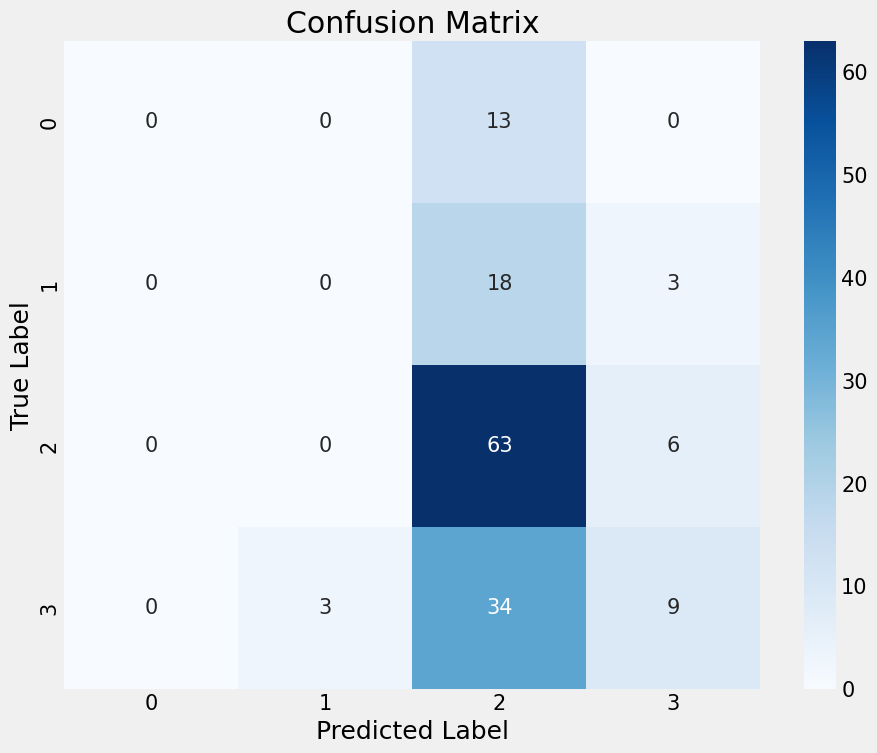

In [122]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


def test(model, testloader, device, num_classes=4):
    model.eval()
    running_accuracy = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for (
            images,
            seg,
            slope,
            labels,
        ) in testloader:  # Corrected to match your data structure
            images = images.float().to(device)
            seg = seg.float().to(device)
            slope = slope.float().to(device)
            labels = labels.to(device)

            outputs = model(images, slope)  # Assuming your model uses images and slope
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            running_accuracy += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * running_accuracy / total
    print(f"Accuracy of the model based on the test set is: {accuracy:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Print classification report
    class_names = [f"Class {i}" for i in range(num_classes)]
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return accuracy, cm


# Usage
test_accuracy, test_cm = test(vit_model, testloader, device)

# If you want to visualize the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [123]:
# 1. Verify model loading
print("1. Verifying model loading...")
best_model_path = "best_clf_model_improved.pth"
vit_model.load_state_dict(torch.load(best_model_path))
vit_model = vit_model.to(device)
print(f"Model loaded from {best_model_path}")

# 2. Check class distribution
print("\n2. Checking class distribution...")


def check_class_distribution(dataloader):
    class_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    for _, _, _, labels in dataloader:
        for label in labels:
            class_counts[label.item()] += 1
    total = sum(class_counts.values())
    return {k: f"{v} ({v/total:.2%})" for k, v in class_counts.items()}


print("Training set class distribution:")
print(check_class_distribution(trainloader))
print("Validation set class distribution:")
print(check_class_distribution(valloader))
print("Test set class distribution:")
print(check_class_distribution(testloader))

# 3. Verify data preprocessing
print("\n3. Verifying data preprocessing...")
# Add a check here to ensure your test data is preprocessed the same way as your training data

# 4. Test on a small subset of training data
print("\n4. Testing on a small subset of training data...")


def test_on_subset(model, dataloader, device, num_batches=5):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, seg, slope, labels) in enumerate(dataloader):
            if i >= num_batches:
                break
            images = images.float().to(device)
            slope = slope.float().to(device)
            labels = labels.to(device)
            outputs = model(images, slope)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


train_subset_acc = test_on_subset(vit_model, trainloader, device)
print(f"Accuracy on training subset: {train_subset_acc:.2f}%")

# 5. Visualize some misclassified examples
print("\n5. Visualizing misclassified examples...")


def visualize_misclassified(model, dataloader, device, num_examples=5):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, seg, slope, labels in dataloader:
            images = images.float().to(device)
            slope = slope.float().to(device)
            labels = labels.to(device)
            outputs = model(images, slope)
            _, predicted = torch.max(outputs.data, 1)
            misclassified.extend(
                [
                    (img, true, pred)
                    for img, true, pred in zip(images, labels, predicted)
                    if true != pred
                ]
            )
            if len(misclassified) >= num_examples:
                break

    # Visualization code here (you may need to adjust based on your image format)
    # for img, true, pred in misclassified[:num_examples]:
    #     plt.imshow(img.cpu().permute(1, 2, 0))
    #     plt.title(f"True: {true.item()}, Predicted: {pred.item()}")
    #     plt.show()


visualize_misclassified(vit_model, testloader, device)

# 6. Print model architecture
print("\n6. Printing model architecture...")
print(vit_model)

# 7. Re-run test with verbose output
print("\n7. Re-running test with verbose output...")


def verbose_test(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0.0 for i in range(4))
    class_total = list(0.0 for i in range(4))
    with torch.no_grad():
        for images, seg, slope, labels in testloader:
            images = images.float().to(device)
            slope = slope.float().to(device)
            labels = labels.to(device)
            outputs = model(images, slope)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print(f"Accuracy of the network on the test images: {100 * correct / total:.2f} %")
    for i in range(4):
        print(f"Accuracy of class {i} : {100 * class_correct[i] / class_total[i]:.2f}%")


verbose_test(vit_model, testloader, device)

1. Verifying model loading...
Model loaded from best_clf_model_improved.pth

2. Checking class distribution...
Training set class distribution:
{0: '46 (12.71%)', 1: '43 (11.88%)', 2: '143 (39.50%)', 3: '130 (35.91%)'}
Validation set class distribution:
{0: '9 (7.44%)', 1: '18 (14.88%)', 2: '49 (40.50%)', 3: '45 (37.19%)'}
Test set class distribution:
{0: '13 (8.72%)', 1: '21 (14.09%)', 2: '69 (46.31%)', 3: '46 (30.87%)'}

3. Verifying data preprocessing...

4. Testing on a small subset of training data...
Accuracy on training subset: 17.50%

5. Visualizing misclassified examples...

6. Printing model architecture...
VisionTransformerMLP(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, ele

In [125]:
# 1. Verify model loading
print("1. Verifying model loading...")
best_model_path = "best_clf_model2.pth"
vit_model.load_state_dict(torch.load(best_model_path))
vit_model = vit_model.to(device)
print(f"Model loaded from {best_model_path}")

# 2. Check class distribution
print("\n2. Checking class distribution...")


def check_class_distribution(dataloader):
    class_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    for _, _, _, labels in dataloader:
        for label in labels:
            class_counts[label.item()] += 1
    total = sum(class_counts.values())
    return {k: f"{v} ({v/total:.2%})" for k, v in class_counts.items()}


print("Training set class distribution:")
print(check_class_distribution(trainloader))
print("Validation set class distribution:")
print(check_class_distribution(valloader))
print("Test set class distribution:")
print(check_class_distribution(testloader))

# 3. Verify data preprocessing
print("\n3. Verifying data preprocessing...")
# Add a check here to ensure your test data is preprocessed the same way as your training data

# 4. Test on a small subset of training data
print("\n4. Testing on a small subset of training data...")


def test_on_subset(model, dataloader, device, num_batches=5):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, seg, slope, labels) in enumerate(dataloader):
            if i >= num_batches:
                break
            images = images.float().to(device)
            slope = slope.float().to(device)
            labels = labels.to(device)
            outputs = model(images, slope)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


train_subset_acc = test_on_subset(vit_model, trainloader, device)
print(f"Accuracy on training subset: {train_subset_acc:.2f}%")

# 5. Visualize some misclassified examples
print("\n5. Visualizing misclassified examples...")


def visualize_misclassified(model, dataloader, device, num_examples=5):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, seg, slope, labels in dataloader:
            images = images.float().to(device)
            slope = slope.float().to(device)
            labels = labels.to(device)
            outputs = model(images, slope)
            _, predicted = torch.max(outputs.data, 1)
            misclassified.extend(
                [
                    (img, true, pred)
                    for img, true, pred in zip(images, labels, predicted)
                    if true != pred
                ]
            )
            if len(misclassified) >= num_examples:
                break

    # Visualization code here (you may need to adjust based on your image format)
    # for img, true, pred in misclassified[:num_examples]:
    #     plt.imshow(img.cpu().permute(1, 2, 0))
    #     plt.title(f"True: {true.item()}, Predicted: {pred.item()}")
    #     plt.show()


visualize_misclassified(vit_model, testloader, device)

# 6. Print model architecture
print("\n6. Printing model architecture...")
print(vit_model)

# 7. Re-run test with verbose output
print("\n7. Re-running test with verbose output...")


def verbose_test(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0.0 for i in range(4))
    class_total = list(0.0 for i in range(4))
    with torch.no_grad():
        for images, seg, slope, labels in testloader:
            images = images.float().to(device)
            slope = slope.float().to(device)
            labels = labels.to(device)
            outputs = model(images, slope)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print(f"Accuracy of the network on the test images: {100 * correct / total:.2f} %")
    for i in range(4):
        print(f"Accuracy of class {i} : {100 * class_correct[i] / class_total[i]:.2f}%")


verbose_test(vit_model, testloader, device)

1. Verifying model loading...
Model loaded from best_clf_model2.pth

2. Checking class distribution...
Training set class distribution:


KeyboardInterrupt: 